### Загрузка библиотек

In [1]:
!python.exe -m pip install --upgrade pip
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install openpyxl
!pip install doubleml
!pip install bnlearn
!pip install --upgrade bnlearn
!pip install catboost
!pip install causalml

/bin/bash: line 1: python.exe: command not found
  Using cached bnlearn-0.11.1-py3-none-any.whl.metadata (15 kB)
  Using cached pgmpy-0.1.25-py3-none-any.whl.metadata (6.4 kB)
  Using cached ismember-1.0.6-py3-none-any.whl.metadata (4.8 kB)
  Using cached df2onehot-1.0.8-py3-none-any.whl.metadata (3.3 kB)
  Using cached datazets-1.1.2-py3-none-any.whl.metadata (13 kB)
  Using cached lingam-1.9.1-py3-none-any.whl.metadata (8.3 kB)
  Using cached pygam-0.9.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached psy-0.0.1-py2.py3-none-any.whl.metadata (5.9 kB)
  Using cached semopy-2.3.11-py3-none-any.whl
  Using cached numdifftools-0.9.41-py2.py3-none-any.whl.metadata (39 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
Using cached bnlearn-0.11.1-py3-none-any.whl (82 kB)
Using cached pgmpy-0.1.25-py3-none-any.whl (2.0 MB)
Using cached datazets-1.1

In [2]:
!pip install pysr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.3/99.3 kB 3.9 MB/s eta 0:00:00


In [1]:
# подгружаем необходимые библиотеки
# базовые операции
import numpy as np
import pandas as pd
from copy import deepcopy
import math
from itertools import product
# визуализация данных
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
# статистические пакеты
import scipy as scipy
from scipy.stats import multivariate_normal
# модели
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor # градиентный бустинг и случайный лес
from sklearn.naive_bayes import GaussianNB, CategoricalNB # наивный Байесовский классификатор
from sklearn.linear_model import LogisticRegression, LinearRegression, LassoCV, RidgeCV # регрессии
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor # k-ближайших соседей
# метрики
from sklearn.metrics import accuracy_score, recall_score, make_scorer, roc_curve, auc, RocCurveDisplay, roc_auc_score, confusion_matrix, mean_squared_error, mean_absolute_percentage_error, precision_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import label_binarize
# другое
from sklearn.base import clone
import doubleml as dml # двойное машинное обучение
import bnlearn # Байесовские сети
from catboost import CatBoostClassifier # подбор параметров при помощи Сatboost (задание 3.9)
from sklearn.preprocessing import OrdinalEncoder # кодировка категориальных признаков
from sklearn.preprocessing import StandardScaler # для масштабирования данных
from sklearn.pipeline import Pipeline
from sklearn.neighbors import NearestNeighbors # k-ближайших соседей без учителя (пункт 5.4)
from statsmodels.discrete.discrete_model import Probit
from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor


# Генерация данных




### №2.1

**Y**: количество потребляемого алкоголя в граммах чистого спирта в течение последнего месяца.

**X**:
- переменная воздействия: наличие сильного стресса за последний месяц (да/нет);
- инструмент: руководящая позиция на работе (да/нет);
- пол;
- возраст;
- доход;
- проживает в городе или в деревне;
- генетическая склонность к депрессии (по шкале от 1 до 10);
- количество товаров по скидке в ближайшем магазине "Красное и Белое".



Целевая переменная:

$$\text{Alcohol}_{i} = \alpha \text{Stress}_{i} + g(\text{Gender}_{i},\text{Age}_{i}, \text{Income}_{i}, \text{City}_{i}, \text{Depressive}_{i}, \text{Store}_{i}) + \varepsilon_{i}^{\text{Alcohol}}$$

Переменная воздействия:

$$\text{Stress}_{i} = g_{\text{stress}}(\text{Boss}_{i},\text{City}_{i}, \text{Depressive}_{i}) + \varepsilon_{i}^{\text{Stress}}$$

Инструментальная переменная:

$$\text{Boss}_{i} = g_{\text{boss}}(\text{Age}_{i}) + \varepsilon_{i}^{\text{boss}}$$

**Допущения о распределении**

Все переменные и случайные ошибки предполагаются независимыми и одинаково распределенными между наблюдениями, то есть по $i\in\{1,...n\}$, где $n$ - число наблюдений.

$$\text{E}(\varepsilon^{\text{Alcohol}}_{i}|\text{Gender}_{i},\text{Age}_{i}, \text{Income}_{i}, \text{City}_{i}, \text{Depressive}_{i}, \text{Store}_{i})=0$$

$$\text{E}(\varepsilon^{\text{Stress}}_{i}|\text{Boss}_{i},\text{City}_{i},\text{Depressive}_{i})=0$$

$$\text{E}(\varepsilon^{\text{Boss}}_{i}|\text{Age}_{i})=0$$

### №2.3

In [2]:
n = 15000
np.random.seed(141)

Симулируем контрольные переменные
- $\text{Gender}_{i}$ из распределенния Бернулли с p = 0.51, то есть $\text{Bernoulli}(0.51)$
- $\text{Age}_{i}$ из нормального распределения с математическим ожиданием $\mu=40$ и стандартным отклонением $\sigma=15 $, то есть $\text{N}\left(40, 15^2\right)$
- $\text{City}_{i}$ из распределенния Бернулли с p = 0.8, то есть $\text{Bernoulli}(0.8)$
- $\text{Depressive}_{i}$ из нормального распределения с математическим ожиданием $\mu=4$ и стандартным отклонением $\sigma=$ 3, то есть $\text{N}\left(4, 3^2\right)$
- $\text{Discounts}_{i}$ из нормального распределения с математическим ожиданием $\mu=200$ и стандартным отклонением $\sigma=$ 50, то есть $\text{N}\left(200, 50^2\right)$

In [3]:
np.random.seed(141)
# Пол
gender = np.random.binomial(1, 0.51, n)
print({'gender': gender[0:10]})

# Возраст
age = scipy.stats.norm.rvs(size = n, loc = 40, scale = 15)
age[age >= 90] = 90                                 # усечение
age[age <= 1]  = 1
age = np.round(age)
print({'age': age[0:10]})

# Тип населенного пункта
city = np.random.binomial(1, 0.8, n)
print({'city': city[0:10]})

# Уровень склонности к депрессии
depressive = scipy.stats.norm.rvs(size = n, loc = 4, scale = 3)
depressive[depressive >= 10] = 10                                 # усечение
depressive[depressive <= 1]  = 1
depressive = np.round(depressive)
print({'depressive': depressive[0:10]})

# Количество скидочных товаров в магазине Красное и Белое
discounts = scipy.stats.norm.rvs(size = n, loc = 200, scale = 50)
discounts[discounts >= 500] = 500                                 # усечение
discounts[discounts <= 1]  = 1
discounts = np.round(discounts)
print({'discounts': discounts[0:10]})

{'gender': array([0, 0, 1, 1, 0, 1, 1, 0, 0, 1])}
{'age': array([45., 60., 34., 57., 37., 41., 49., 21., 33., 26.])}
{'city': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])}
{'depressive': array([5., 5., 2., 2., 1., 2., 1., 5., 9., 4.])}
{'discounts': array([157.,  51., 151., 264., 236., 139., 209.,  95., 115., 189.])}


$$P(\text{Boss}_{i} = 1| \text{Age}_{i}) = F_{\text{Student}}\left(\ln\left(\text{Age}_{i}\right) - 4\right)$$

In [4]:
np.random.seed(141)
# Условная вероятность руководящей должности
boss_prob = scipy.stats.t.cdf(x = np.log(age) - 4, df = 5) #среднее - 0.37
# Является ли боссом или нет
boss = np.random.binomial(n = 1, p = boss_prob, size = n)
boss_prob.mean(), boss

(0.37257094609065317, array([1, 1, 0, ..., 1, 0, 0]))

$$\text{Income}_{i} = {15000 + 5000 * \text{Gender}_{i} + 2500 * \sqrt{\text{Age}_{i}} - 2 * \text{Age}_{i}^2 + 600 * \text{Age}_{i}} + \varepsilon_{income}$$

In [5]:
np.random.seed(141)
# Доход
error_income = scipy.stats.norm.rvs(size = n, scale = 5000, loc = 0)
income = 15000 + 5000 * gender + 2500 * np.sqrt(age) - 2 * age ** 2 + 600 * age + error_income #cреднее 53492
income[income <= 0]  = 0
income = np.round(income)
print({'income': income[0:10]}, income.mean())

{'income': array([54947., 67392., 52200., 63870., 45803., 59642., 62651., 36909.,
       46698., 47324.])} 53492.41393333334


Text(0, 0.5, 'Частота')

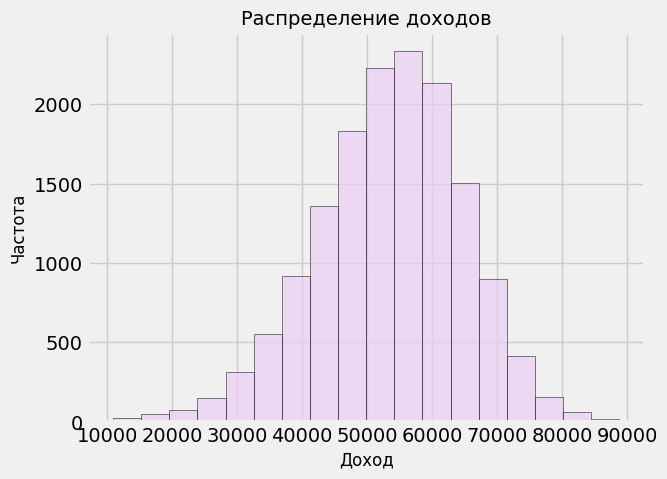

In [6]:
plt.hist(income, bins=18, alpha=0.7, color='#ebcef4', edgecolor='black')
plt.title('Распределение доходов', fontsize=14)
plt.xlabel('Доход', fontsize=12)
plt.ylabel('Частота', fontsize=12)

$$P(\text{Stress}_{i} = 1|\text{Boss}_{i}, \text{City}_{i}, \text{Depressive}_{i}) = F_{\text{Logistic}}\left(3*\sqrt{2 * \text{City}_{i} + 6 * \text{Boss}_{i} + 3 * \text{Boss}_{i}^2 + \text{Depressive}_{i}} - 9\right)$$

In [7]:
np.random.seed(141)
# Пороги
u = scipy.stats.uniform.rvs(size = n)

# Симулируем, есть ли стресс
# если человек на руководящей должности
boss1 = 1
stress_prob1 = scipy.stats.logistic.cdf(
    3 * np.sqrt(2 * city + 6 * boss1 + 3 * boss1 ** 2 + depressive) - 9) #среднее 0.89
stress1 = (stress_prob1 >= u).astype(int)

# Симулируем, есть ли стресс
# если человек НЕ на руководящей должности
boss0 = 0
stress_prob0 = scipy.stats.logistic.cdf(
    3 * np.sqrt(2 * city + 6 * boss0 + 3 * boss0 ** 2 + depressive) - 9) #среднее 0.21
stress0 = (stress_prob0 >= u).astype(int)

# Соблюдатели
compliers = stress1 > stress0

# Факт наличия у индивида стресса
stress = np.zeros(n)
stress[boss == 1] = stress1[boss == 1]
stress[boss == 0] = stress0[boss == 0]

# Доли людей со стрессом и соблюдателей
print(pd.DataFrame(data    = [np.mean(compliers), np.mean(stress)],
                   index   = ['P(compliers = 1)', 'P(stress = 1)'],
                   columns = ['Оценка']))

                    Оценка
P(compliers = 1)  0.681467
P(stress = 1)     0.465733


Уравнение для количества потребляемого спирта (в граммах) при отсутствии стресса.


$$\text{Alcohol}_{0i} = \underbrace{165 + 100 * \text{Gender}_{i} - 0.01 \sqrt {\text{Income}_{i}} + 8 * {\text{Depressive}_{i}^2 - 25 * \text{City}_{i} + 10 * \sqrt{\text{Age}_{i} + \text{Discounts}_{i}}}}_{g_{0}(X_{i})} + \varepsilon_{0i}$$

Уравнение для количества потребляемого спирта (в граммах) при наличии стресса.

$$
\text{Alcohol}_{1i} =
200 +
250 * \text{Gender}_i +
12 * \text{Depressive}_i^2 +
3 * \ln(\text{Income}_i) -
\frac{0.0005 * \text{Income}_{i}}{10 - \text{Depressive}_i^2} +
0.05 * \text{Age}_i^2 -
275 * \text{City}_i +
1.2 * \text{Discounts}_i +
\varepsilon_{1i}
$$



Наблюдаемое количество потребляемого спирта в граммах в месяц

$$\text{Alcohol}_{i} = \begin{cases}\text{Alcohol}_{1i}\text{, если }\text{Stress}_{i}=1\\ \text{Alcohol}_{0i}\text{, если }\text{Stress}_{i}=0\end{cases}$$

In [8]:
np.random.seed(141)
# Случайная ошибка
error_alcohol0 = scipy.stats.norm.rvs(size = n, scale = 75, loc = 0) # у людей без стресса больше разброс
error_alcohol1 = scipy.stats.norm.rvs(size = n, scale = 50, loc = 0)

# значение без случайной ошибки
g0 =  165 + 100 * gender - 0.01 * np.sqrt(income) + 8 * depressive ** 2 - 25 * city + 10 * np.sqrt(age + discounts)
g1 = 200 + 250 * gender + 12 * depressive ** 2 + 3 * np.log(income) - 0.0005 * income/(10 - depressive ** 2) + 0.05 * age ** 2 - 275 * city + 1.2 * discounts


# значение со случайной ошибкой
alcohol0 = 165 + 100 * gender - 0.01 * np.sqrt(income) + 8 * depressive ** 2 - 25 * city + 10 * np.sqrt(age + discounts) + error_alcohol0 #543 среднее
alcohol1 = 200 + 250 * gender + 12 * depressive ** 2 + 3 * np.log(income) - 0.0005 * income/(10 - depressive ** 2) + 0.05 * age ** 2 - 275 * city + 1.2 * discounts + error_alcohol1 #764 среднее

# Наблюдаемое потребление алкоголя
alcohol = np.zeros(n)
alcohol[stress == 0] = alcohol0[stress == 0]
alcohol[stress == 1] = alcohol1[stress == 1]

In [9]:
alcohol1.mean(), alcohol0.mean()

(764.149996049135, 543.3538493013593)

Text(0, 0.5, 'Частота')

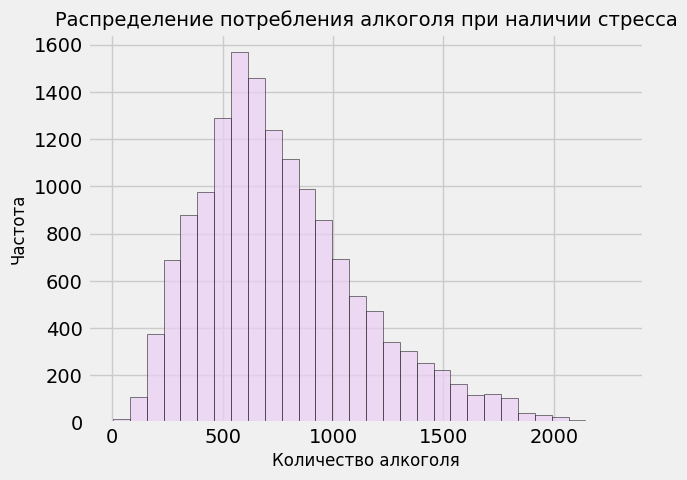

In [10]:
plt.hist(alcohol1, bins=30, alpha=0.7, color='#ebcef4', edgecolor='black')
plt.title('Распределение потребления алкоголя при наличии стресса', fontsize=14)
plt.xlabel('Количество алкоголя', fontsize=12)
plt.ylabel('Частота', fontsize=12)

Text(0, 0.5, 'Частота')

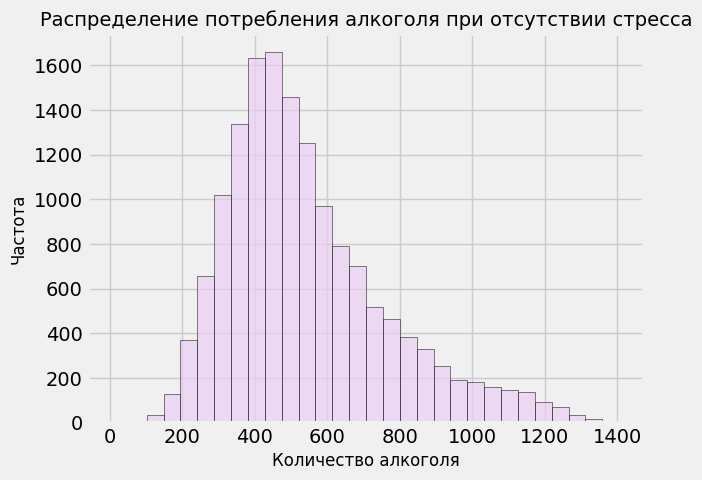

In [11]:
plt.hist(alcohol0, bins=30, alpha=0.7, color='#ebcef4', edgecolor='black')
plt.title('Распределение потребления алкоголя при отсутствии стресса', fontsize=14)
plt.xlabel('Количество алкоголя', fontsize=12)
plt.ylabel('Частота', fontsize=12)

Text(0, 0.5, 'Частота')

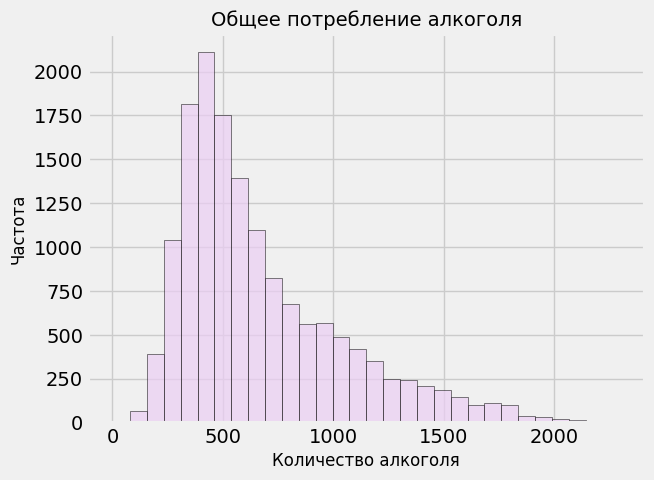

In [12]:
plt.hist(alcohol, bins=30, alpha=0.7, color='#ebcef4', edgecolor='black')
plt.title('Общее потребление алкоголя', fontsize=14)
plt.xlabel('Количество алкоголя', fontsize=12)
plt.ylabel('Частота', fontsize=12)

In [13]:
# Агрегируем данные в датафрейм
df = pd.DataFrame({'gender': gender,       'age': age,
                   'income': income,   'stress': stress,
                   'city': city,    'depressive': depressive,
                   'boss': boss, 'discounts': discounts, 'alcohol': alcohol})

# Посмотрим на симулированные данные
df.head(10)

,gender,age,income,stress,city,depressive,boss,discounts,alcohol
0,0,45.0,54947.0,1.0,1,5.0,1,157.0,547.924271
1,0,60.0,67392.0,1.0,1,5.0,1,51.0,558.516383
2,1,34.0,52200.0,1.0,1,2.0,0,151.0,492.424415
3,1,57.0,63870.0,1.0,1,2.0,1,264.0,723.525197
4,0,37.0,45803.0,1.0,1,1.0,1,236.0,455.145156
5,1,41.0,59642.0,0.0,1,2.0,0,139.0,439.665321
6,1,49.0,62651.0,0.0,1,1.0,0,209.0,414.409465
7,0,21.0,36909.0,0.0,1,5.0,0,95.0,426.793354
8,0,33.0,46698.0,1.0,1,9.0,1,115.0,1102.846673
9,1,26.0,47324.0,0.0,1,4.0,0,189.0,517.383902


Ниже можно увидеть схему всех взаимосвязей между переменными.

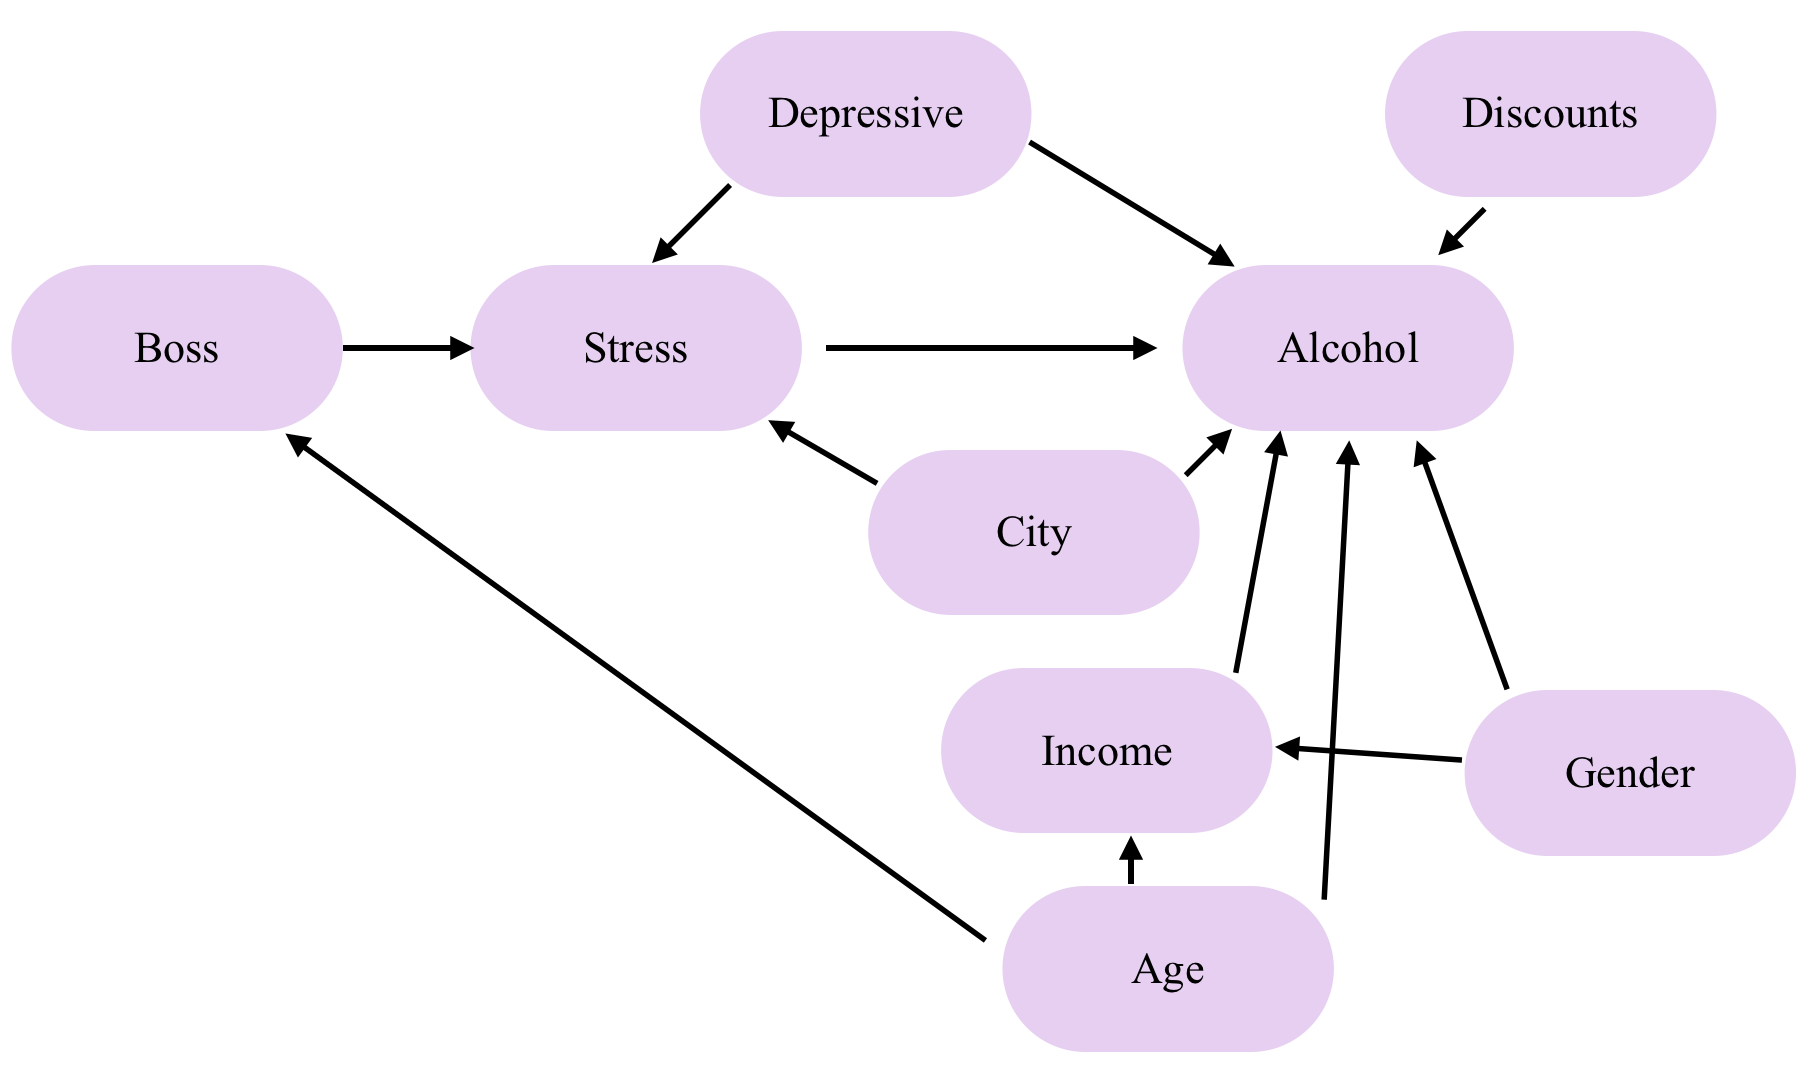

In [14]:
df['boss'].corr(df['stress']) #смотрим, чтобы у инструмента и переменной воздействия была сильная связь (релевантность)

0.48720794257919187

In [15]:
df['boss'].corr(df['alcohol']) #смотрим, чтобы у инструмента и зависимой переменной была слабая связь (валидность)

0.052416793275825546

In [16]:
min(df['alcohol']) #проверяем, чтобы потребление алкоголя было неотрицательным

3.3741861916788096

Еще раз убедимся, что сгенерированные данные удовлетворяют требованиям задания

In [17]:
print(len(df)) #15 000 > 1 000
print(df['gender'].mean()) #0.1<0.5<0.9
print(df['boss'].mean()) #0.1<0.4<0.9
print(df['city'].mean()) #0.1<0.8<0.9
print(df['stress'].mean()) #0.1<0.5<0.9

15000
0.5079333333333333
0.37593333333333334
0.7972666666666667
0.46573333333333333


Выведем также основные описательные статистики для переменных

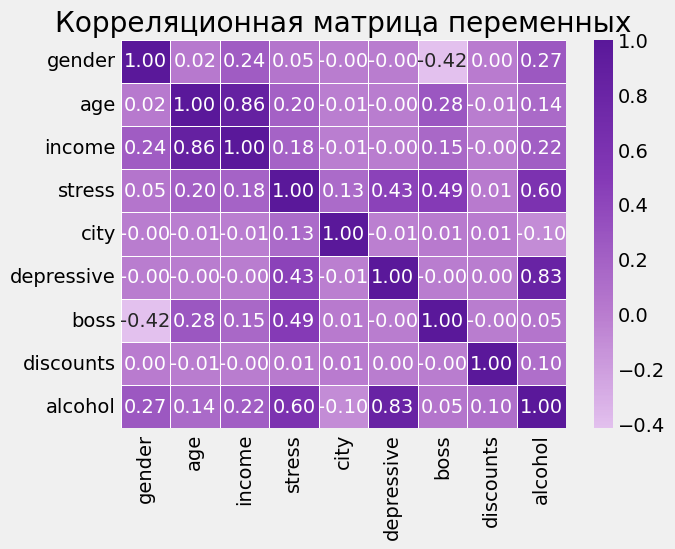

In [18]:
#выводим корреляционную матрицу
corr_matrix = df.corr()
custom_cmap = LinearSegmentedColormap.from_list(
    "lavender_purple",
    ["#f6e6fb", "#ebcef4", "#b97ccf", "#8439b6", "#5a189a"]  # светлый → насыщенный фиолет)
)
sns.heatmap(corr_matrix,
            annot=True,
            fmt=".2f",
            cmap=custom_cmap,
            center=0,
            linewidths=0.5)
plt.title("Корреляционная матрица переменных")
plt.show()

In [19]:
stats_df = pd.DataFrame(columns=['Переменная', 'Среднее', 'Станд. отклонение','Медиана', 'Минимум', 'Максимум'])
for var in ['age', 'income', 'depressive', 'discounts', 'alcohol']:
    stats_df.loc[len(stats_df)] = [
        var,
        round(df[var].mean(), 2),
        round(df[var].std(), 2),
        round(df[var].median(), 2),
        round(df[var].min(), 2),
        round(df[var].max(), 2)]
print("Описательная статистика для непрерывных переменных:")
print(stats_df)

Описательная статистика для непрерывных переменных:
   Переменная   Среднее  Станд. отклонение   Медиана   Минимум  Максимум
0         age     40.22              14.97     40.00      1.00     90.00
1      income  53492.41           11237.34  54192.50  10900.00  88785.00
2  depressive      4.24               2.55      4.00      1.00     10.00
3   discounts    200.84              49.62    200.00     20.00    401.00
4     alcohol    669.58             370.16    554.15      3.37   2296.45


In [20]:
print("Описательная статистики для бинарных переменных:")
print(pd.DataFrame({
    'Доля единиц (%)': df[['gender', 'stress', 'city', 'boss']].mean().round(4) * 100,
    'Количество единиц': (df[['gender', 'stress', 'city', 'boss']].sum()).astype(int)}))

Описательная статистики для бинарных переменных:
        Доля единиц (%)  Количество единиц
gender            50.79               7619
stress            46.57               6986
city              79.73              11959
boss              37.59               5639


# Классификация

### №3.1

Переменная воздействия – наличие стресса у человека за последнее время. Отберем признаки, которые могут влиять на этот показатель:


*   **Пол** – женщины и мужчины могут сталкиваться с различными препятствиями из-за образа жизни и общественных ожиданий. Так, у женщин может быть высокий уровень стресса из-за ухода за детьми, а у мужчин – из-за напряженной работы (как пример);
*   **Возраст** – чем человек старше, тем больше источников стресса у него появляется, так как он сталкивается с различными трудностями в самореализации и личной жизни;
*  **Доход** – чем выше у человека доход, тем ниже может быть его уровень стресса, так как деньги позволяют решать многие жизненные проблемы;
* **Жизнь в городе** – жизнь в мегаполисе является источником стресса, так как навязывает быстрый темп жизни, за которым сложно успеть;
* **Депрессивное состояние** – психологические сложности могут усиливать вес жизненных трудностей, из-за чего уровень стресса выше;
* **Руководящая позиция** – человек, занимающий высокий пост на работе сталкивается с большим количеством задач и ответственностью, что может повышать уровень стресса.

Таким образом, мы используем для классификации все переменные, кроме целевой (потребление алкоголя) и количества скидок.



Теперь поделим выборку на тестовую и обучаемую

In [21]:
x = df[['gender', 'age', 'income', 'boss', 'city', 'depressive']]
y = df['stress']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=141)

### №3.2

Переходим к классификации данных

In [22]:
# задаем словарь с моделями со случайными параметрами
models = {"Naive Bayes": GaussianNB(), # используем такую функцию, так как есть непрерывные переменные – возраст и доход
          "KNN": KNeighborsClassifier(n_neighbors=7),
          "Random Forest": RandomForestClassifier(n_estimators=100, random_state=141),
          "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=141),
          "Logistic Regression": LogisticRegression(max_iter=1000, random_state = 141)}

In [23]:
results = []
for name, model in models.items():
    model.fit(x_train, y_train) #обучение
    train_acc = accuracy_score(y_train, model.predict(x_train)) #точность на обучающей выборке
    test_acc = accuracy_score(y_test, model.predict(x_test)) #точность на тестовой выборке
    cv_acc = np.mean(cross_val_score(model, x_train, y_train, cv=5)) #точность с помощью кросс-валидации
    results.append([name, train_acc, test_acc, cv_acc])

df_results = pd.DataFrame(results, columns=["Model", "Train Accuracy", "Test Accuracy", "CV Accuracy"])

In [24]:
df_results

,Model,Train Accuracy,Test Accuracy,CV Accuracy
0,Naive Bayes,0.813778,0.804533,0.814222
1,KNN,0.692089,0.556000,0.552089
2,Random Forest,0.999911,0.841600,0.841511
3,Gradient Boosting,0.876267,0.862400,0.865689
4,Logistic Regression,0.858578,0.847200,0.857333


Интерпретация результатов:


*   Наивный Байесовский классификатор показал неплохую точность и минимальную разницу между выборками, однако есть инструменты точнее;
*   KNN хуже всего предсказывает в сравнении с остальными моделями. Это может быть связано с неправильным подбором числа соседей, а также с отсутствием масштабирования данных (так, между уровнем депрессии и доходами очень большая вариативность);
*   Random Forest показывает явное переобучение – на обучающей выборке точность почти 1, а на тестовой и кросс-валидационной падает. Требуется подбор гиперпараметров;
*   Градиентный бустинг и логистическая регрессия показывают сравнимые результаты – высокая точность и практически отсутствующее переобучение.

Пока самой точной моделью является градиентный бустинг.


### №3.3

Теперь пробуем делать тюнинг

In [25]:
# создаем словарь с параметрами для перебора (у Naive Bayes нет параметров)
param_grid = {"KNN": {"n_neighbors": [3, 5, 7, 9]},
    "Random Forest": {"n_estimators": [50, 100, 150], "max_depth": [None, 5, 10]},
    "Gradient Boosting": {"n_estimators": [50, 100, 150], "learning_rate": [0.01, 0.1, 0.2]},
     "Logistic Regression": {
        "C": [0.01, 0.1, 1, 10],
        "max_iter": [500, 1000, 2000]}}

results_tuned = []
for name, model in models.items():
    if name in param_grid: # если в модели есть параметры для перебора
        grid = GridSearchCV(model, param_grid[name], cv=5, scoring='accuracy', n_jobs=-1) # ACC в качестве критерия
        grid.fit(x_train, y_train)
        best_model = grid.best_estimator_
        tuned_params = grid.best_params_
    else:
        best_model = model # если нет параметров для перебора
        best_model.fit(x_train, y_train)
        tuned_params = "N/A"

    # расчет метрик
    tuned_train_acc = accuracy_score(y_train, best_model.predict(x_train)) # точность лучшей модели на обучающей выборке
    tuned_test_acc = accuracy_score(y_test, best_model.predict(x_test)) # точность лучшей модели на тестовой выборке
    tuned_cv_acc = np.mean(cross_val_score(best_model, x_train, y_train, cv=5)) # точность лучшей модели с помощью кросс-валидации
    results_tuned.append([name, tuned_params, tuned_train_acc, tuned_test_acc, tuned_cv_acc])

df_tuned = pd.DataFrame(results_tuned, columns=["Model", "Tuned Params", "Train Accuracy", "Test Accuracy", "CV Accuracy"])

In [26]:
# убираем ограничения на ширину колонок, чтобы полностью видеть параметры
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
pd.reset_option("display.float_format") # сбрасываем формат вывода чисел

df_tuned

,Model,Tuned Params,Train Accuracy,Test Accuracy,CV Accuracy
0,Naive Bayes,N/A,0.813778,0.804533,0.814222
1,KNN,{'n_neighbors': 3},0.785956,0.555200,0.556267
2,Random Forest,"{'max_depth': 5, 'n_estimators': 150}",0.868178,0.863733,0.865422
3,Gradient Boosting,"{'learning_rate': 0.1, 'n_estimators': 100}",0.876267,0.862400,0.865689
4,Logistic Regression,"{'C': 0.1, 'max_iter': 500}",0.859378,0.846667,0.859644


In [27]:
# объединяем таблицы с результатами до и после тюнинга гиперпараметров
df_final = df_results.merge(df_tuned, on="Model", how="inner", suffixes=('_Init', '_Tuned'))

# добавляем столбец с изначальными параметрами
initial_params = {
    "Naive Bayes": "N/A (невозможно настроить)",
    "KNN": "{'n_neighbors': 7}",
    "Random Forest": "{'max_depth': None, 'n_estimators': 100}",
    "Gradient Boosting": "{'learning_rate': None, 'n_estimators': 100}",
    "Logistic Regression": "{'C': None, 'max_iter': 1000}"}

df_final['Initial Params'] = df_final['Model'].map(initial_params)
cols = df_final.columns.tolist()
cols.insert(cols.index('Model') + 1, cols.pop(cols.index('Initial Params')))
df_final = df_final[cols]

In [28]:
df_final

,Model,Initial Params,Train Accuracy_Init,Test Accuracy_Init,CV Accuracy_Init,Tuned Params,Train Accuracy_Tuned,Test Accuracy_Tuned,CV Accuracy_Tuned
0,Naive Bayes,N/A (невозможно настроить),0.813778,0.804533,0.814222,N/A,0.813778,0.804533,0.814222
1,KNN,{'n_neighbors': 7},0.692089,0.556000,0.552089,{'n_neighbors': 3},0.785956,0.555200,0.556267
2,Random Forest,"{'max_depth': None, 'n_estimators': 100}",0.999911,0.841600,0.841511,"{'max_depth': 5, 'n_estimators': 150}",0.868178,0.863733,0.865422
3,Gradient Boosting,"{'learning_rate': None, 'n_estimators': 100}",0.876267,0.862400,0.865689,"{'learning_rate': 0.1, 'n_estimators': 100}",0.876267,0.862400,0.865689
4,Logistic Regression,"{'C': None, 'max_iter': 1000}",0.858578,0.847200,0.857333,"{'C': 0.1, 'max_iter': 500}",0.859378,0.846667,0.859644


Интерпретация результатов:


*   Наивный Байесовский классификатор не изменился (так как отсутствуют параметры для перебора);
*   Точность KNN выросла на обучающей выборке, но практически не изменилась на двух остальных – теперь разница еще более значительная, что может указывать на переобучение. KNN остался худшим методом классификации – вероятно, это связано с разностью масштабов переменных;
*   В Random Forest удалось избежать переобучения благодаря ограничению глубины деревьев. Теперь модель сопоставима по точности с градиентным бустингом и логистической регрессией;
*   Точность градиентного бустинга не изменилась – случайно подобранные параметры оказались лучшими из всех, что мы перебирали. Точность логистической регрессии немного выросла.

После тюнинга можно сказать, что хуже всего (если оценивать точность при помощи кросс-валидации) с задачей классификации справился KNN, а лучше всего – градиентный бустинг (сравнимо с ним Random Forest и логистическая регрессия). Важно учесть, что для моделей мы перебирали очень небольшое число параметров из-за ограничений в вычислительной мощности, поэтому нельзя точно утверждать, что мы подобрали идеальные параметры.

**Повышенная сложность**  – подбор параметров случайного леса через OOB ошибки. Суть метода заключается в том, что при подборе параметров используется не отдельная валидационная выборка, а те наблюдения, которые не попали в бустрап-выборку (это и будут out-of-bag). Каждое дерево делает предсказание только на своих OOB-наблюдениях, а итоговая точность находится как средняя точность предсказаний по всем деревьям.

In [29]:
# создаем словарь с параметрами для перебора
params_oob = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 10, 25, 50],
    'max_features': [1, 2, 3],
    'max_samples': [200, 500, 1000],
    'min_samples_leaf': [3, 5, 10, 25]
}

param_combinations_oob = product(*params_oob.values()) # создаем все возможные комбинации параметров
# переменные для сохранения результатов
oob_scores = []
best_oob_score = -1
best_model = None

for n_est, depth, features, samples, leaf in param_combinations_oob:
    rf = RandomForestClassifier(
        n_estimators=n_est,
        max_depth=depth,
        max_features=features,
        max_samples=samples,
        min_samples_leaf=leaf,
        criterion='entropy', # критерий – энтропия
        oob_score=True,
        n_jobs=-1,
        random_state=141
    )
    rf.fit(x_train, y_train)
    y_pred = rf.predict(x_test)  # делаем предсказания на тестовой выборке
    test_accuracy = accuracy_score(y_test, y_pred)  # считаем точность на тестовой выборке
    # добавляем результаты в массив
    oob_scores.append([n_est, depth, features, samples, leaf, rf.oob_score_, test_accuracy])

# создаем таблицу с результатами
df_oob = pd.DataFrame(oob_scores, columns=['n_estimators', 'max_depth', 'max_features', 'max_samples', 'min_samples_leaf', 'oob_score', 'test_accuracy'])
# сортируем таблицу, чтобы в начале получить комбинацию с лучшим oob-score
df_oob_sorted = df_oob.sort_values('oob_score', ascending=False)
df_oob_sorted

,n_estimators,max_depth,max_features,max_samples,min_samples_leaf,oob_score,test_accuracy
356,100,50,3,1000,3,0.868622,0.858133
320,100,25,3,1000,3,0.868622,0.858133
104,50,10,3,1000,3,0.867911,0.861600
140,50,25,3,1000,3,0.867822,0.858933
176,50,50,3,1000,3,0.867822,0.858933
...,...,...,...,...,...,...,...
279,100,10,3,200,25,0.817778,0.814133
243,100,5,3,200,25,0.817778,0.814133
3,50,3,1,200,25,0.816444,0.808800
387,150,3,3,200,25,0.814756,0.809867


Лучшей моделью согласно OOB стала модель с параметрами n_estimators = 100, max_depth = 50, max_features = 3, max_samples = 1000, min_samples_leaf = 3. Точность на тестовой выборке оказалась равна 0.8581. При кросс-валидации точность на тестовой выборке составляла 0.864, то есть при работе с oob-ошибками она немного снизилась.
Относительно предыдущего подбора, в oob модели выше максимальная глубина (50 против 5), но при этом уменьшилось количество деревьев (100 против 150).


Преимущества:


*   **Скорость** – OOB рассчитываются автоматически во время обучения Random Forest, не нужно делить данные на фолды (что замедляет работу кода);
*   **Данные** – при OOB все данные участвуют как в обучении, так и в тестировании (для разных деревьев данные то будут входить в OOB, то нет).


Недостатки:
*   **Снижение точности на тестовой выборке**;
*   **Ограниченность моделей** – если кросс-валидацию можно использовать на разных моделях и сравнивать их между собой, то OOB подходит только для моделей с бэггингом (таких как случайный лес);
*   **Контроль разбиения**  – если при кросс-валидации можно самостоятельно контролировать количество фолдов, то OOB-ошибки рассчитываются автоматически и не дают возможности для контроля.

В нашей модели оба метода привели к сопоставимым оценкам, что говорит об устойчивости обоих.

### №3.4

Далее поработаем с альтернативной метрикой выбора. В качестве нее мы будем использовать Recall, так как нам важно максимально охватить все реальные положительные случаи (именно Recall показывает чувствительность, так как $Recall = \frac{\text{TP}}{\text{TP + FN}}$).

Прогнозирование уровня стресса можно использовать для назначения лечения, при этом, лечение не будет дорогостоящим и не несет серьезных последстий для здоровья, поэтому ложноположительные случаи не так важны (то есть FN дороже, чем FP) – лучше "перелечить" человека и выписать ненужное лекарство, чем пропустить действительно больного, у которого проблемы со стрессом могут привести к более серьезным психическим заболеваниям. Благодаря этому мы можем "жертвовать" Precision в пользу Recall. Данные уже достаточно сбаланированные (доля людей со стрессом 0.47), поэтому можно работать только с Recall, а не с F1.

In [30]:
# набор параметров для перебора остается тем же
# те же действия, что в предыдущем разделе, но с другой метрикой качества
results_tuned_recall = []
for name, model in models.items():
    if name in param_grid:
        grid = GridSearchCV(model, param_grid[name], cv=5, scoring='recall', n_jobs=-1) # меняем метрику на recall
        grid.fit(x_train, y_train)
        best_model = grid.best_estimator_
        tuned_params_recall = grid.best_params_
    else:
        best_model = model
        best_model.fit(x_train, y_train)
        tuned_params_recall = "N/A"

#расчет метрик
    tuned_train_recall = recall_score(y_train, best_model.predict(x_train)) # расчет recall на обучающей выборке
    tuned_test_recall = recall_score(y_test, best_model.predict(x_test)) # расчет recall на тестовой выборке
    tuned_cv_recall = cross_val_score(best_model, x_train, y_train, cv=5, scoring='recall').mean() # расчет recall при кросс-валидации
    results_tuned_recall.append([name, tuned_params_recall, tuned_train_recall, tuned_test_recall, tuned_cv_recall])

df_tuned_recall = pd.DataFrame(results_tuned_recall, columns=["Model", "Tuned Params Recall", "Train Recall", "Test Recall", "CV Recall"])

In [31]:
df_tuned_recall

,Model,Tuned Params Recall,Train Recall,Test Recall,CV Recall
0,Naive Bayes,N/A,0.790326,0.778674,0.791084
1,KNN,{'n_neighbors': 3},0.757380,0.514697,0.514184
2,Random Forest,"{'max_depth': 5, 'n_estimators': 50}",0.850124,0.856484,0.850124
3,Gradient Boosting,"{'learning_rate': 0.1, 'n_estimators': 100}",0.858694,0.850720,0.862503
4,Logistic Regression,"{'C': 10, 'max_iter': 500}",0.840030,0.832277,0.840031


In [32]:
# рассчитываем Recall для изначального набора параметров для сравнения
results_recall = []
for name, model in models.items():
    model.fit(x_train, y_train)
    train_recall = recall_score(y_train, model.predict(x_train))
    test_recall = recall_score(y_test, model.predict(x_test))
    cv_recall = np.mean(cross_val_score(model, x_train, y_train, cv=5, scoring = 'recall'))
    results_recall.append([name, train_recall, test_recall, cv_recall])

df_results_recall = pd.DataFrame(results_recall, columns=["Model", "Train Recall", "Test Recall", "CV Recall"])
df_results_recall

,Model,Train Recall,Test Recall,CV Recall
0,Naive Bayes,0.790326,0.778674,0.791084
1,KNN,0.636260,0.487608,0.484286
2,Random Forest,0.999810,0.829971,0.829176
3,Gradient Boosting,0.858694,0.850720,0.862503
4,Logistic Regression,0.839840,0.832277,0.839650


In [33]:
# объединяем таблицу со значениями до и после подбора гиперпараметров
df_final_recall = df_results_recall.merge(df_tuned_recall, on="Model", how="inner", suffixes=('_Init', '_Tuned'))

# добавляем столбец с изначальными параметрами
df_final_recall['Initial Params'] = df_final_recall['Model'].map(initial_params)
cols = df_final_recall.columns.tolist()
cols.insert(cols.index('Model') + 1, cols.pop(cols.index('Initial Params')))
df_final_recall = df_final_recall[cols]
df_final_recall

,Model,Initial Params,Train Recall_Init,Test Recall_Init,CV Recall_Init,Tuned Params Recall,Train Recall_Tuned,Test Recall_Tuned,CV Recall_Tuned
0,Naive Bayes,N/A (невозможно настроить),0.790326,0.778674,0.791084,N/A,0.790326,0.778674,0.791084
1,KNN,{'n_neighbors': 7},0.636260,0.487608,0.484286,{'n_neighbors': 3},0.757380,0.514697,0.514184
2,Random Forest,"{'max_depth': None, 'n_estimators': 100}",0.999810,0.829971,0.829176,"{'max_depth': 5, 'n_estimators': 50}",0.850124,0.856484,0.850124
3,Gradient Boosting,"{'learning_rate': None, 'n_estimators': 100}",0.858694,0.850720,0.862503,"{'learning_rate': 0.1, 'n_estimators': 100}",0.858694,0.850720,0.862503
4,Logistic Regression,"{'C': None, 'max_iter': 1000}",0.839840,0.832277,0.839650,"{'C': 10, 'max_iter': 500}",0.840030,0.832277,0.840031


Интерпретация результатов:


*   Как и раньше, наивный Байесовский классификатор не изменился после тюнинга гиперпараметров. Он остался надежной моделью с небольшой разницей внутри выборок, но есть модели лучше;
*   KNN осталась худшей моделью для предсказания – как до, так и после тюнинга между обучающей выборкой и кросс-валидационным значением большая разница. При этом, сами значения Recall ниже (до тюнинга гиперпараметров) или лишь немного выше (после тюнинга) 0.5 на тестовой и кросс-валидационной выборках. Это значит, что среди всех случаев Stress = 1 модель верно классифицирует только половину. Как и раньше, такое значение метрики может быть связано с разным масштабом переменных;
*   Random Forest изначально показывал переобучение, однако после ограничения глубины и числа деревьев стала близка по показателям с лучшими моделями;
*   Градиентный бустинг и логистическая регрессия продолжают показывать стабильные результаты как до, так и после тюнинга гиперпараметров. В градиентом бустинге опять же случайно выбранный параметр оказался наиболее подходящим.

При оценке Recall хуже всех оказался метод k-ближайших соседей, а чувствительнее всего – градиентный бустинг.


Преимущества Recall в сравнении с Accuracy:


*   **Учет разного веса предсказаний** – Recall позволяет минимизировать ложноотрицательные предсказания (FN). В нашем случае это было важно, чтобы провести профилактическое лечение и не пропустить человека со стрессом;
*   **Учет дисбаланса классов** – Accuracy может давать завышенные результаты, если данные были несбалансированы, в то время как Recall показывает долю *истинно* положительных результатов.

Недастатки Recall:
*   **Влияние на FN предсказания** – модель может увеличить число ложноположительных случаев. Выявление слишком большого числа случаев стресса может увеличить нагрузку на здравоохранительную систему и вызвать настороженность в обществе. В итоге профилактические лекарства потеряют смысл (не стоит забывать, что побочные эффекты хоть и небольшие, но всё равно присутствуют). Из-за этого страдает Precision.

Таким образом, чтобы найти баланс между Recall и Precision для оценки качества моделей лучше использовать F1-метрику (будет использована в пункте 3.8).

**Повышенная сложность**: в качестве критерия для тюнинга гиперпараметров попробуем использовать среднее из всех доступных метрик – Accuracy, Precision, Recall и F1.

In [34]:
# задаем функцию кастомизированной метрики в зависимости от истинного и предсказанного значений
def custom_classification_metric(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return (accuracy + precision + recall + f1) / 4  # Среднее всех метрик

custom_scorer = make_scorer(custom_classification_metric)

# подбор аналогичен подбору в пункте 3.3
results_tuned_custom = []
for name, model in models.items():
    if name in param_grid:
        grid = GridSearchCV(model, param_grid[name], cv=5, scoring=custom_scorer, n_jobs=-1) # добавляем в качестве метрики собственный вариант
        grid.fit(x_train, y_train)
        best_model = grid.best_estimator_
        tuned_params = grid.best_params_
    else:
        best_model = model
        best_model.fit(x_train, y_train)
        tuned_params = "N/A"

    # рассчитываем кастомную метрику для всех выборок
    tuned_train_custom_score = custom_classification_metric(y_train, best_model.predict(x_train))
    tuned_test_custom_score = custom_classification_metric(y_test, best_model.predict(x_test))
    tuned_cv_custom_score = np.mean(cross_val_score(best_model, x_train, y_train, cv=5, scoring=custom_scorer))

    # также рассчитываем стандартные показатели
    # на тестовой выборке
    tuned_test_accuracy = accuracy_score(y_test, best_model.predict(x_test))
    tuned_test_precision = precision_score(y_test, best_model.predict(x_test))
    tuned_test_recall = recall_score(y_test, best_model.predict(x_test))
    tuned_test_f1 = f1_score(y_test, best_model.predict(x_test))
    # при помощи кросс-валидации
    tuned_cv_accuracy = np.mean(cross_val_score(best_model, x_train, y_train, cv=5, scoring = 'accuracy'))
    tuned_cv_precision = np.mean(cross_val_score(best_model, x_train, y_train, cv=5, scoring = 'precision'))
    tuned_cv_recall = np.mean(cross_val_score(best_model, x_train, y_train, cv=5, scoring = 'recall'))
    tuned_cv_f1 = np.mean(cross_val_score(best_model, x_train, y_train, cv=5, scoring = 'f1'))

    # добавляем результаты в массив
    results_tuned_custom.append([name, tuned_params, tuned_train_custom_score, tuned_test_custom_score, tuned_cv_custom_score,
        tuned_test_accuracy, tuned_test_precision, tuned_test_recall, tuned_test_f1,
        tuned_cv_accuracy, tuned_cv_precision, tuned_cv_recall, tuned_cv_f1])

# создаем дата-фрейм с результатами
columns = ["Model", "Tuned Params", "Train Custom Score", "Test Custom Score", "CV Custom Score",
    "Test Accuracy", "Test Precision", "Test Recall", "Test F1",
    "CV Accuracy", "CV Precision", "CV Recall", "CV F1"]
df_tuned_custom = pd.DataFrame(results_tuned_custom, columns=columns)
df_tuned_custom

,Model,Tuned Params,Train Custom Score,Test Custom Score,CV Custom Score,Test Accuracy,Test Precision,Test Recall,Test F1,CV Accuracy,CV Precision,CV Recall,CV F1
0,Naive Bayes,N/A,0.802332,0.791131,0.802829,0.804533,0.794706,0.778674,0.786608,0.814222,0.807053,0.791084,0.798957
1,KNN,{'n_neighbors': 3},0.772268,0.526617,0.528783,0.555200,0.519488,0.514697,0.517082,0.556267,0.525142,0.514184,0.519538
2,Random Forest,"{'max_depth': 5, 'n_estimators': 150}",0.860339,0.855970,0.857563,0.863733,0.849714,0.857061,0.853372,0.865422,0.860591,0.849362,0.854876
3,Gradient Boosting,"{'learning_rate': 0.1, 'n_estimators': 100}",0.868812,0.854008,0.859263,0.862400,0.851702,0.850720,0.851211,0.865689,0.851797,0.862503,0.857064
4,Logistic Regression,"{'C': 0.1, 'max_iter': 500}",0.850597,0.836716,0.850747,0.846667,0.837995,0.828818,0.833382,0.859644,0.858882,0.836793,0.847669


Интерпретация результатов:


*   Для наивного Байесовского классификатора результаты не изменились (не было параметров для улучшения);
*   Для KNN результаты также не изменились: и при использовании Accuracy, и при Recall, и при кастомизированной метрике оптимальное число соседей – 3 (при этом KNN является худшей моделью по всем метрикам и по всем выборкам);
*   Для Случайного леса, градиентного бустинга и логистической регрессии использование кастомной метрики привело к таким же параметрам, что и использование Accuracy. Использование Recall привело к чуть большему значению этой метрики, но принципиальной разницы нет. Три модели всё еще очень близки друг к другу по всем метрикам.

Вывод: использование кастомной метрики не дало существенных отличий по сравнению с использованием Accuracy. Модели с использованием Recall в качестве метрики отбора логично давали большее значение именно по этому показателю. Для иных результатов можно пробовать давать разные веса разным метрикам или использовать больше параметров для перебора.

Плюсы кастомизированной метрики:


*   **Баланс в предсказаниях** – новая метрика позволяет учитывать все предсказания, что делает ее наиболее сбалансированной к объектам всех классов;
*   **Учет дисбаланса в данных** – сбалансированная метрика позволяет не думать о дисбалансе в данных, который может влиять на метрики (например, на Accuracy);
*   **Возможности для дополнительной кастомизации** – с помощью введения коэффициентов перед метриками можно задать значимость, если какой-то определенный тип предсказаний более важен, чем остальные;

Минусы кастомизированной метрики:


*   **Интерпретация** – без дополнительного анализа непонятно, как интерпретировать полученное значение, так как непонятно, какая из классических метрик привела к результатам. Для интерпретации нужно дополнительно строить классические метрики, чтобы понять, какой из типов предсказаний модель определяет хуже или лучше;
*   **Скорость**  – модель работает дольше, однако в нашем случае привела к таким же результатам, что и оптимизация с помощью Accuracy.

Вывод: конкретно для нашего набора параметров кастомизированная оптимизация не имеет смысла, так как дает те же параметры, что и Accuracy, однако работает дольше и требует дополнительных параметров для интерпретации. Однако она может быть полезна, если разница между классическими метриками значительна или если в данных присутствует дисбаланс.

Ниже приведен график для сравнения метрик на кросс-валидационной выборке – Accuracy, Recall и кастомизированная метрика.

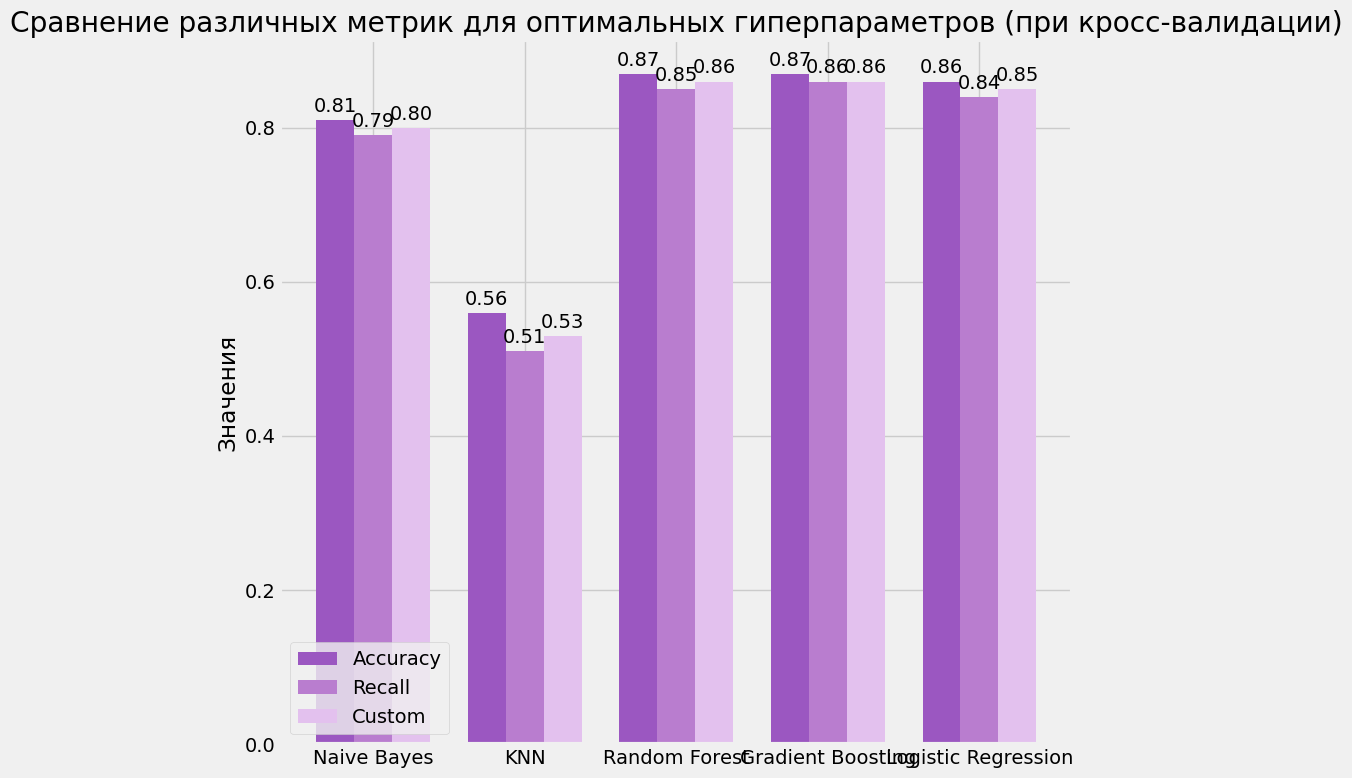

In [35]:
models_list = ['Naive Bayes', 'KNN', 'Random Forest', 'Gradient Boosting', 'Logistic Regression']
metrics = {'Accuracy': [0.81, 0.56, 0.87, 0.87, 0.86],
    'Recall': [0.79, 0.51, 0.85, 0.86, 0.84],
    'Custom': [0.80, 0.53, 0.86, 0.86, 0.85]}

x_len = np.arange(len(models_list))
width = 0.25

fig, ax = plt.subplots(figsize=(9, 8))
rects1 = ax.bar(x_len - width, metrics['Accuracy'], width, label='Accuracy', color='#9b57c1')
rects2 = ax.bar(x_len, metrics['Recall'], width, label='Recall', color = '#b97dcf')
rects3 = ax.bar(x_len + width, metrics['Custom'], width, label='Custom', color = '#e3c1ee')

# Добавление подписей значений
ax.bar_label(rects1, padding=3, fmt='%.2f')
ax.bar_label(rects2, padding=3, fmt='%.2f')
ax.bar_label(rects3, padding=3, fmt='%.2f')

ax.set_ylabel('Значения')
ax.set_title('Cравнение различных метрик для оптимальных гиперпараметров (при кросс-валидации)')
ax.set_xticks(x_len)
ax.set_xticklabels(models_list)
ax.legend()
plt.tight_layout()
plt.show()

### №3.5

Построим ROC-кривую для модели, настроенной с помощью критерия Accuracy.

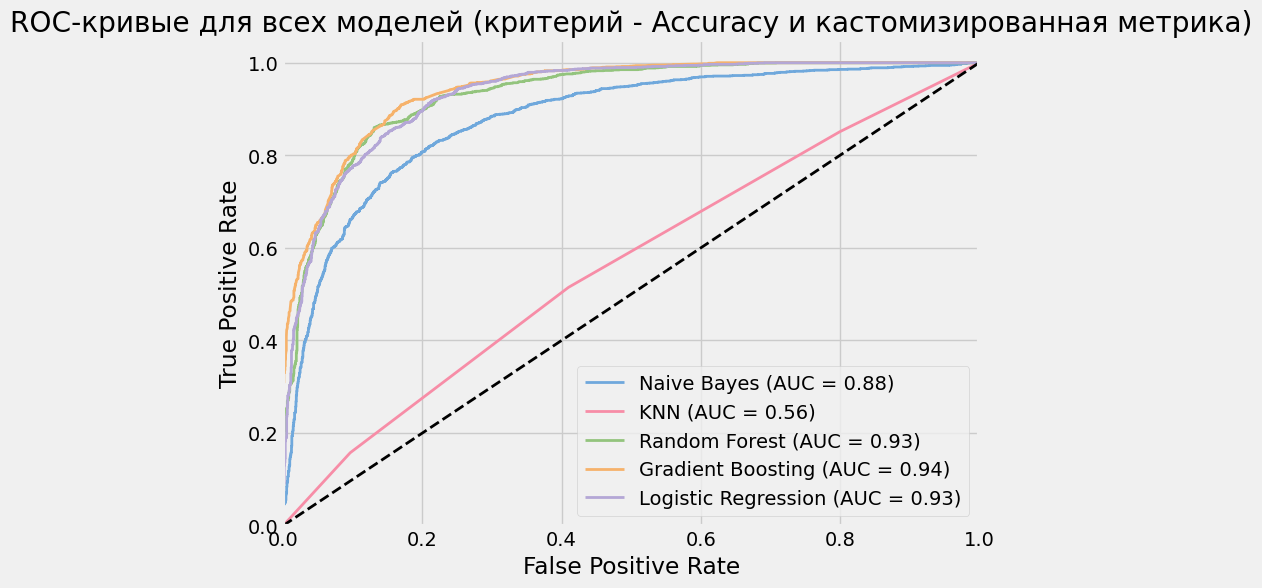

In [36]:
# строим ROC-кривые для модели с подбором параметров через Accuracy
plt.figure(figsize=(8, 6))
colors = ['#6FA8DC', '#F78DA7', '#93C47D', '#F6B26B', '#B4A7D6']
model_names = ['Naive Bayes', 'KNN', 'Random Forest', 'Gradient Boosting', 'Logistic Regression']

# создаем словарь с оптимальными значениями (пункт 3.3)
best_models_acc = {
    'Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier(n_neighbors=3),
    'Random Forest': RandomForestClassifier(n_estimators = 150, max_depth=5, random_state=141),
    'Gradient Boosting': GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, random_state=141),
    'Logistic Regression': LogisticRegression(C=0.1, max_iter=500, random_state=141)}

# обучаем лучшие модели
for name, model in best_models_acc.items():
    model.fit(x_train, y_train)

# вычисляем AUC и строим кривую
for (name, model), color in zip(best_models_acc.items(), colors):
    y_proba = model.predict_proba(x_test)[:, 1] # вероятность принадлежности к классу Stress = 1
    fpr, tpr, _ = roc_curve(y_test, y_proba) # высчитываем FPR и TPR на основе тестовой выборки и вероятности
    roc_auc_model = auc(fpr, tpr) # вычисляем площадь под кривой
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{name} (AUC = {roc_auc_model:.2f})') # рисуем кривую с подписью

# создаем график и добавляем туда рандомный классификатор
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для всех моделей (критерий - Accuracy и кастомизированная метрика)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Интерпретация:

Как видно, KNN справляется с классификацией лишь немного лучше, чем случайный классификатор. Наивный Байесовский классификатор получился достаточно гладким, но его ROC-кривая ниже трех лучших моделей. Случайный лес, градиентный бустинг и логистическая регрессия показывают сопоставимые результаты.

Для кастомизированной метрики график идентичен по всем показателям.

Рассмотрим также модель с подбором параметров для случайного леса через oob-ошибки.

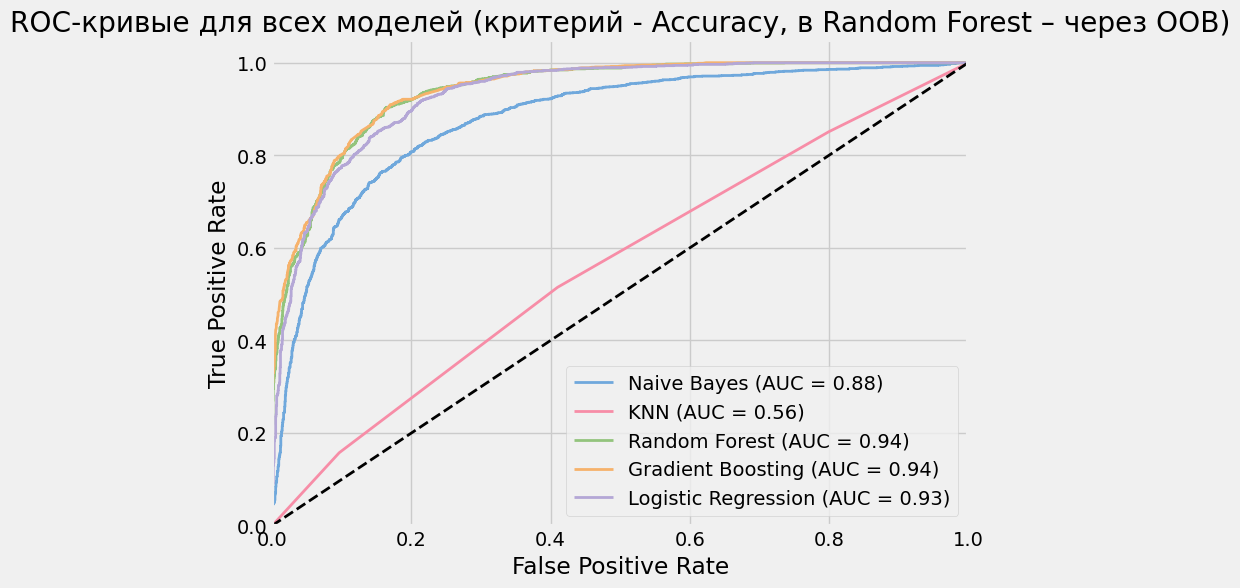

In [37]:
# строим ROC-кривые для модели с подбором параметров через Accuracy (кроме случайного леса)
plt.figure(figsize=(8, 6))
colors = ['#6FA8DC', '#F78DA7', '#93C47D', '#F6B26B', '#B4A7D6']
model_names = ['Naive Bayes', 'KNN', 'Random Forest', 'Gradient Boosting', 'Logistic Regression']

# создаем словарь с оптимальными значениями (пункт 3.3, повышенная сложность)
best_models_oob = {
    'Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier(n_neighbors=3),
    'Random Forest': RandomForestClassifier(n_estimators = 100, max_depth=50, max_features = 3, max_samples = 1000, min_samples_leaf=3, random_state=141),
    'Gradient Boosting': GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, random_state=141),
    'Logistic Regression': LogisticRegression(C=0.1, max_iter=500, random_state=141)}

# обучаем лучшие модели
for name, model in best_models_oob.items():
    model.fit(x_train, y_train)

# вычисляем AUC и строим кривую
for (name, model), color in zip(best_models_oob.items(), colors):
    y_proba = model.predict_proba(x_test)[:, 1] # вероятность принадлежности к классу Stress = 1
    fpr, tpr, _ = roc_curve(y_test, y_proba) # высчитываем FPR и TPR на основе тестовой выборки и вероятности
    roc_auc_model = auc(fpr, tpr) # вычисляем площадь под кривой
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{name} (AUC = {roc_auc_model:.2f})') # рисуем кривую с подписью

# создаем график и добавляем туда рандомный классификатор
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для всех моделей (критерий - Accuracy, в Random Forest – через OOB)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Интерпретация:

Немного вырос AUС для случайного леса. При этом, если раньше логистическая регрессия и случайный лес менялись местами, то в этой модели ROC-кривая случайного леса всегда выше.

Теперь построим те же кривые, но с другим критерием подбора – Recall.

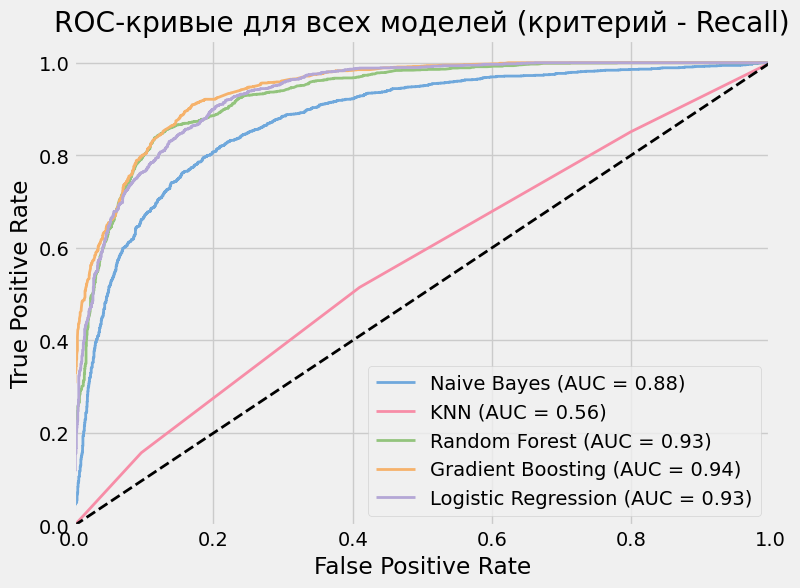

In [38]:
# строим ROC-кривые для модели с подбором параметров через Recall

plt.figure(figsize=(8, 6))
colors = ['#6FA8DC', '#F78DA7', '#93C47D', '#F6B26B', '#B4A7D6']
model_names = ['Naive Bayes', 'KNN', 'Random Forest', 'Gradient Boosting', 'Logistic Regression']

# создаем словарь с оптимальными значениями (пункт 3.4)
best_models_recall = {
    'Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier(n_neighbors=3),
    'Random Forest': RandomForestClassifier(max_depth=5, n_estimators=50, random_state=141),
    'Gradient Boosting': GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, random_state=141),
    'Logistic Regression': LogisticRegression(C=10, max_iter=500, random_state=141)
}

# обучаем модель
for name, model in best_models_recall.items():
    model.fit(x_train, y_train)

# вычисляем AUC и строим кривую
for (name, model), color in zip(best_models_recall.items(), colors):
    y_proba = model.predict_proba(x_test)[:, 1] # предсказанные значения
    fpr, tpr, _ = roc_curve(y_test, y_proba) # вычисляем FPR и TPR
    roc_auc_model = auc(fpr, tpr) # вычисляем AUC
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{name} (AUC = {roc_auc_model:.2f})') # строим кривую

# создаем график и добавляем туда рандомный классификатор
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для всех моделей (критерий - Recall)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Интерпретация:

Изменение кривых и AUC минимальное по сравнению с Accuracy. Для трех моделей параметры вообще не меняются (Наивный Байесовский классификатор, k-ближайших соседей, градиентный бустинг), а для случайного леса и логистической регрессии изменения параметров практически не поменяли кривые.

Для наглядности также построим модель со случайным (изначальным) набором параметров.

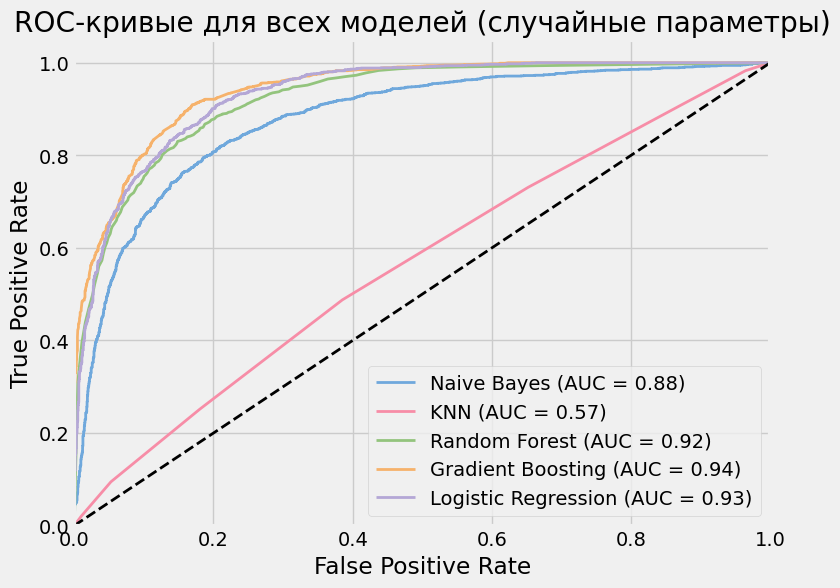

In [39]:
# строим ROC-кривые для модели со случайными параметрами

plt.figure(figsize=(8, 6))
colors = ['#6FA8DC', '#F78DA7', '#93C47D', '#F6B26B', '#B4A7D6']
model_names = ['Naive Bayes', 'KNN', 'Random Forest', 'Gradient Boosting', 'Logistic Regression']

# берем модели из словаря с изначальными значениями – models
for name, model in models.items():
    model.fit(x_train, y_train)

# Строим ROC-кривые для всех моделей
for (name, model), color in zip(models.items(), colors):
    y_proba = model.predict_proba(x_test)[:, 1] # расчет предсказаний
    fpr, tpr, _ = roc_curve(y_test, y_proba) # расчет FPR и TPR
    roc_auc_model = auc(fpr, tpr) # расчет AUC
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{name} (AUC = {roc_auc_model:.2f})')

# строим график и добавляем случайный классификатор
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для всех моделей (случайные параметры)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Интерпретация:

Как видно, тюнинг не сильно изменил результаты моделей. Наивный Байес и градиентный бустинг не изменились (случайно выбранные параметры оказались оптимальными среди перебирыемых). AUC KNN даже немного выше при случайном параметре (7 соседей), а случайный лес и логистическая регрессия, несмотря на изменение параметров, почти не меняются в значении AUC.

По всем метрикам наилучшей моделью оказался градиентный бустинг.

### №3.6

Перейдем к прогнозированию с учетом цен прогнозов.
В контексте нашей задачи возможны следующие прогнозы:


*   **TP (true positive)** - спрогнозировали, что у индивида был стресс и у него в действительности он был: $$\text{Stress}_{i} = 1\qquad \widehat{\text{Stress}}_{i}=1$$
*   **TN (true negative)** - спрогнозировали, что у индивида не было стресса и его в действительности не было: $$\text{Stress}_{i} = 0\qquad \widehat{\text{Stress}}_{i}=0$$
*   **FP (false positive)** - спрогнозировали, что у индивида был стресс, а на самом деле его не было: $$\text{Stress}_{i} = 0\qquad \widehat{\text{Stress}}_{i}=1$$
*   **FN (false negative)** - спрогнозировали, что у индивида не было стресса, а на самом деле он был: $$\text{Stress}_{i} = 1\qquad \widehat{\text{Stress}}_{i}=0$$

Для начала построим матрицу ошибок. В качестве параметров модели будем использовать модели с подбором при помощи Accuracy.

In [40]:
# используем параметры из подбора параметров с критерием Accuracy
# обучаем модели
for model in best_models_acc.values():
    model.fit(x_train, y_train)

confusion_results = pd.DataFrame(columns=['Model', 'TP', 'TN', 'FP', 'FN'])

for name, model in best_models_acc.items():
    TN, FP, FN, TP = confusion_matrix(y_test, model.predict(x_test)).ravel() # рассчитываем ошибки для тестовой выборки
    confusion_results.loc[len(confusion_results)] = [name, TP, TN, FP, FN]

print(confusion_results)

                 Model    TP    TN   FP   FN
0          Naive Bayes  1351  1666  349  384
1                  KNN   893  1189  826  842
2        Random Forest  1487  1752  263  248
3    Gradient Boosting  1476  1758  257  259
4  Logistic Regression  1438  1737  278  297


Интерпретация:



*   Случайный лес, градиентный бустинг и логистическая регрессия дают сопоставимые результаты. Все три модели делают много TP и TN предсказаний, TP больше у Random Forest, а TN – у бустинга;
*   KNN чаще остальных моделей делает ложные прогнозы – как ложноположительные, так и ложноотрицательные;
*   Байесовский классификатор делает много точных прогнозов, но делает ошибок каждого типа (FP и FN) примерно на 100 больше, чем три лучшие модели.



Вернемся к мысли о назначении лекарст. Так как лекарства не очень дорогие, для нас важнее не пропустить больного (FN), чем "переназначить" лекарства здоровым (FP). Будем учитывать это при выборе цены.

Используем следующую логику. Пусть исследует стресс больница, которая назначает лечение и сама же продает лекарства. Лекарство стоит 50 монет, а его себестоимость - 10 монет. При неверном назначении больница несет не только сами издержки (на изготовление лекарств), но и репутационные потери. Можно предположить следующие цены прогнозов:


*   **TP** – у человека был стресс и ему назначили лечение. Больница получает 50 - 10 = 40 монет;
*   **TN** – у человека не было стресса и ему не назначили лечение. Больница ничего не получает, но и ничего не теряет. Прибыль – 0 монет;
*   **FP** – у человека не было стресса, но ему ошибочно назначили лечение. Больница получила 40 монет, но несет возможные репутационные риски -50, общая прибыль составит -10 монет;
*   **FN** – у человека был стресс, но ему не назначили лечение. Больница несет репутационные издержки -50.

In [41]:
prices = pd.Series([40, 0, -10, -50], index = ["TP", "TN", "FP", "FN"]) # задаем цены для разного вида прогнозов

In [42]:
# создаем датафрейм для результатов
results_threshold = pd.DataFrame(columns=['Model', 'AUC', 'Optimal Threshold', 'Test Profit', 'TP', 'TN', 'FP', 'FN'])

# перебираем модели из словаря моделей, подобранных при помощи Accuracy
for name, model in best_models_acc.items():
    prob_train = model.predict_proba(x_train)[:, 1] # вероятность того, что стресс есть на обучающей выборке
    prob_test = model.predict_proba(x_test)[:, 1] # вероятность того, что стресс есть на тестовой выборке

    # создаем уникальные значения для перебора
    thresholds = np.unique(np.sort(prob_train))

    # создаем изначальное значение порога (0.5) и прибыль для сравнения (минус бесконечность)
    best_threshold = 0.5
    best_profit = -np.inf

    # создаем цикли для проверки всех пороговых значений
    for threshold in thresholds:
        preds = (prob_train >= threshold).astype(int) # сравниваем значение из обучающей выборки с порогом: если вероятность выше порога, то 1, если ниже – 0
        TN, FP, FN, TP = confusion_matrix(y_train, preds).ravel() # считаем прогнозы разного вида
        profit = TP*prices['TP'] + TN*prices['TN'] + FP*prices['FP'] + FN*prices['FN'] # считаем прибыль в соответствии с выбранными ценами
        # меняем прибыль и порог, если текущая прибыль показалась выше оптимальной
        if profit > best_profit:
            best_profit = profit
            best_threshold = threshold

    # используем оптимальный порог на тестовой выборке
    test_preds = (prob_test >= best_threshold).astype(int) # создаем предсказания на основе лучшего порога
    TN_test, FP_test, FN_test, TP_test = confusion_matrix(y_test, test_preds).ravel() # считаем прогнозы разного вида
    test_profit = TP_test*prices['TP'] + TN_test*prices['TN'] + FP_test*prices['FP'] + FN_test*prices['FN'] # считаем прибыль от оптимального порога
    # вычисляем AUC на тестовой выборке
    auc_threshold = roc_auc_score(y_test, test_preds)
    #добавляем полученные результаты в таблицу
    results_threshold.loc[len(results_threshold)] = [name, auc_threshold, best_threshold, test_profit, TP_test, TN_test, FP_test, FN_test]

# сортируем результат по прибыли
results_threshold = results_threshold.sort_values('Test Profit', ascending=False)
results_threshold

,Model,AUC,Optimal Threshold,Test Profit,TP,TN,FP,FN
3,Gradient Boosting,0.805834,0.156851,58910,1701,1272,743,34
4,Logistic Regression,0.797022,0.150074,58790,1704,1233,782,31
2,Random Forest,0.767245,0.188440,57590,1704,1113,902,31
0,Naive Bayes,0.630816,0.136021,51700,1699,569,1446,36
1,KNN,0.525608,0.333333,29980,1476,404,1611,259


Интерпретация результатов:


*   AUC всех моделей снизился – это значит, что модели начали хуже различать положительные и отрицательные классы. При этом моделью с самым высоким AUC остался градиентный бустинг;
*   Так как за FN был самый большой штраф, этих предсказаний стало меньше для всех моделей;
*   Градиентный бустинг и логистическая регрессия остались очень близки между собой, в то время как рандомный лес начал делать больше ложноположительных предсказаний (возможно, из-за небольшой разницы в цене между TN и TP);
*   Наивный Байес делает много TP предсказаний, сопоставимо с лучшими моделями, однако гораздо больше FP и меньше TN. Это значит, что классификатор просто чаще стал делать предсказания Stress = 1 – он делает их в 3145 случаях из 3750;
*   KNN показывает AUC лишь немного лучше случайного классификатора и огромную разницу в прибыли с остальными моделями. Как и Байесовский классификатор, модель чаще делает положительные предсказания, но также и чаще всех делает ложноотрицательные (из-за чего падает в прибыли). Это может быть связано с относительно высоким порогом отбора (0.33, в то время как у остальных моделей он примерно в половину меньше). Так как в лучшей модели всего 3 соседа, могло получиться всего 4 значения вероятностей – 0, 0.33, 0.66 и 1. Если бы стоял порог выше 0.33, то снизилось бы количество TP предсказаний, которые имеют наивысшую цену (так как для таких предсказаний у 2 или 3 соседей Stress = 1). Из-за небольшого числа соседей сократилось число возможных порогов, что привело к самым плохим по качеству предсказаниям.

Лучшей моделью по AUC снова оказался градиентный бустинг.

**Повышенная сложность**: в прошлом варианте нам не очень понравилось количество ложноположительных прогнозов. Ненужное лечение оказывает влияние на систему здравоохранения и может повышать репутационные риски, так как пациенты узнают, что им дают ненужные лекарства. Пусть стоимость неверных прогнозов растет не линейно, а экспоненциально. После определенного порога каждая следующая ошибка будет стоить клинике всё дороже. Предположим, что для FP прогнозов такой порог будет составлять 300 ошибок, а для FN – 50 (так как назначение ненужных лекарств обнаружится не сразу). Базовую стоимость оставим той же.

In [43]:
# определяем нелинейную функцию
def nonlinear_profit(TP, TN, FP, FN):
    base_profit = TP*40 + TN*0 # цена за верные прогнозы не меняется
    # расчет для FP – если меньше 300, то обычная цена, если больше, то экспоненциальная
    if FP <= 300:
        fp_penalty = -10 * FP
    else:
        fp_penalty = -10 * FP * np.exp(FP / 300)
    # расчет для FN с границей в 50
    if FN <= 50:
        fn_penalty = -50 * FN
    else:
        fn_penalty = -50 * FN * np.exp(FN / 50)
    return base_profit + fp_penalty + fn_penalty # выводим сумму цен всех прогнозов

# задаем датафрейм для результатов
results_threshold_nonlinear = pd.DataFrame(columns=['Model', 'AUC', 'Optimal Threshold', 'Test Profit', 'TP', 'TN', 'FP', 'FN'])

# повторяем действия из предыдущего пункта
for name, model in best_models_acc.items():
    prob_train = model.predict_proba(x_train)[:, 1]
    prob_test = model.predict_proba(x_test)[:, 1]
    thresholds = np.unique(np.sort(prob_train))
    best_threshold = 0.5
    best_profit = -np.inf
    for threshold in thresholds:
        preds = (prob_train >= threshold).astype(int)
        TN, FP, FN, TP = confusion_matrix(y_train, preds).ravel()
        profit = nonlinear_profit(TP, TN, FP, FN)  # вставляем нелинейную функцию прибыли для расчета
        if profit > best_profit:
            best_profit = profit
            best_threshold = threshold

    # считаем прибыль для лучшего порога
    test_preds = (prob_test >= best_threshold).astype(int)
    TN_test, FP_test, FN_test, TP_test = confusion_matrix(y_test, test_preds).ravel()
    test_profit = nonlinear_profit(TP_test, TN_test, FP_test, FN_test)
    # считаем AUC
    auc_threshold_nonlinear = roc_auc_score(y_test, prob_test)
    # добавляем в фрейм с результатами
    results_threshold_nonlinear.loc[len(results_threshold_nonlinear)] = [name, auc_threshold_nonlinear, best_threshold, round(test_profit, 2),TP_test, TN_test, FP_test, FN_test]

In [44]:
# сортируем результаты по прибыли и выводим таблицу
results_threshold_nonlinear = results_threshold_nonlinear.sort_values('Test Profit', ascending=False)
results_threshold_nonlinear

,Model,AUC,Optimal Threshold,Test Profit,TP,TN,FP,FN
3,Gradient Boosting,0.941594,0.267660,13719.77,1655,1475,540,80
4,Logistic Regression,0.931390,0.293198,8308.64,1647,1479,536,88
2,Random Forest,0.930082,0.256224,-9196.01,1645,1400,615,90
0,Naive Bayes,0.878880,0.289024,-145887.18,1606,1197,818,129
1,KNN,0.564467,0.333333,-5703393.20,1476,404,1611,259


Интерпретация результатов:

AUC моделей совпал с AUC при обычном переборе параметров, значит, наша функция подобрана лучше обычной линейной. Распределение ошибок при этом поменялось – если раньше градиентный бустинг, логистическая регрессия и случайный лес чаще предсказывали TN, то теперь чаще всего предсказываются TP. Значительно удалось снизить значение FN (по сравнению с оптимизацией через Accuracy), но увеличилось и число FP прогнозов. Наивный Байесовский классификатор и КNN продолжают делать большое количество положительных прогнозов, однако первый точнее, так как чаще делает TP прогнозы (у KNN порог не изменился, из-за чего распределение ошибок также осталось прежним). Из-за экспоненциального учета прибыли и достаточно низкой границы у FN прогнозов (после которой идет экспоненциальное начисление прибыли) только у двух лучших моделей положительная прибыль – у градиентного бустинга и логистической регрессии.

Лучшей моделью по AUC остался градиентный бустинг.

### №3.7

Ниже приведена визуализация *истинных* взаимосвязей между переменными без учета алкоголя. Как видно, граф действительно ациклический.

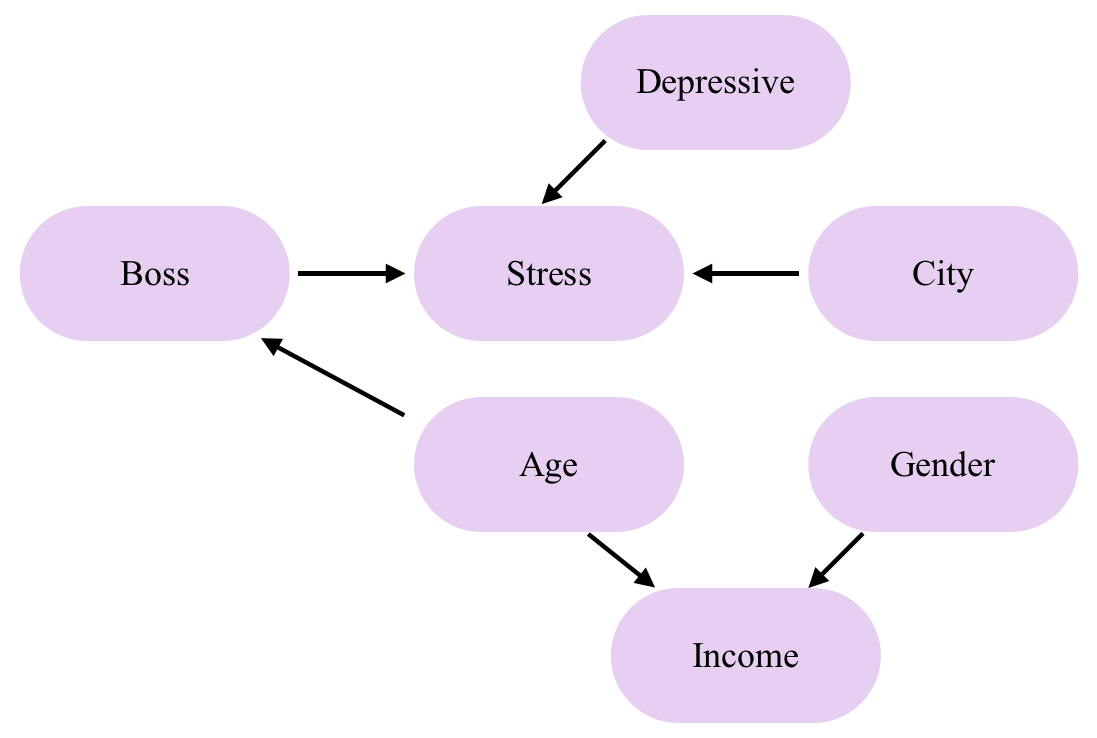

Перейдем к созданию Байесовской сети на основе этого графа.

In [45]:
# создаем DAG
# задаем направление стрелочек
edges = [("boss", "stress"), # (откуда стрелочка, куда стрелочка)
         ("age", "income"),
         ("age", "boss"),
         ("gender", "income"),
         ("depressive", "stress"),
         ("city", "stress")]
# переменная с заданной вручную сетью
DAG   = bnlearn.make_DAG(edges, methodtype = 'bayes')
if 'config' not in DAG:
    DAG['config'] = {'method': 'bayes'}

[bnlearn]> Auto generate placeholders for the CPTs.
[bnlearn] >CPT for stress:
+------------+---------------+-----+---------------+---------------+
| boss       | boss(0)       | ... | boss(1)       | boss(1)       |
+------------+---------------+-----+---------------+---------------+
| depressive | depressive(0) | ... | depressive(1) | depressive(1) |
+------------+---------------+-----+---------------+---------------+
| city       | city(0)       | ... | city(0)       | city(1)       |
+------------+---------------+-----+---------------+---------------+
| stress(0)  | 0.5           | ... | 0.5           | 0.5           |
+------------+---------------+-----+---------------+---------------+
| stress(1)  | 0.5           | ... | 0.5           | 0.5           |
+------------+---------------+-----+---------------+---------------+
[bnlearn] >CPT for income:
+-----------+-----------+-----------+-----------+-----------+
| age       | age(0)    | age(0)    | age(1)    | age(1)    |
+----------

Для того, чтобы bplearn работал корректно, все данные должны быть представлены в категориальном виде. Для этого мы преобразуем данные по возрасту и доходу в 4 категории. Чтобы не менять изначальный датасет, создадим для этого задания его копию.

In [46]:
# создаем копию исходных данных
x_copy = x.copy()
y_copy = y.copy()

In [47]:
# разбиваем непрерывные переменные на категории
# работаем с возрастом – задаем границы
x_copy['age'] = pd.cut(x_copy['age'], bins=[0, 25, 40, 60, 90], labels=['молодой', 'средний', 'взрослый', 'пожилой'])
# работаем с доходом – просто делим на 4 части
x_copy['income'] = pd.qcut(x_copy['income'], q=4, labels=['низкий', 'средний-', 'средний+', 'высокий'])

# преобразуем все данные в категориальные переменные
x_copy = x_copy.astype(str)
y_copy = y_copy.astype(str)

In [48]:
# делим данные
x_train_BN, x_test_BN, y_train_BN, y_test_BN = train_test_split(x_copy, y_copy, test_size=0.25, random_state=141)

# собираем их в единый датафрейм без деления на целевую переменную и признаки
df_train_BN = x_train_BN.copy()
df_train_BN['stress'] = y_train_BN

df_test_BN = x_test_BN.copy()
df_test_BN['stress'] = y_test_BN

In [49]:
#обучаем заданный DAG на обучающей выборке
bn_model = bnlearn.parameter_learning.fit(DAG, df_train_BN, methodtype='ml')

#предсказываем целевую переменную на тестовой выборке
predict_result_BN = bnlearn.predict(bn_model, df=x_test_BN, variables=["stress"])
y_pred_BN = np.array(predict_result_BN['stress'])

#вычисляем точность и выводим ее
bn_test_acc = accuracy_score(y_test_BN, y_pred_BN)
print("Точность DAG на тестовой выборке:", bn_test_acc)

[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >CPD of stress:
+-------------+-----------------+-----+---------------------+
| boss        | boss(0)         | ... | boss(1)             |
+-------------+-----------------+-----+---------------------+
| city        | city(0)         | ... | city(1)             |
+-------------+-----------------+-----+---------------------+
| depressive  | depressive(1.0) | ... | depressive(9.0)     |
+-------------+-----------------+-----+---------------------+
| stress(0.0) | 1.0             | ... | 0.03418803418803419 |
+-------------+-----------------+-----+---------------------+
| stress(1.0) | 0.0             | ... | 0.9658119658119658  |
+-------------+-----------------+-----+---------------------+
[bnlearn] >CPD of income:
+------------------+-----+---------------------+
| age              | ... | age(средний)        |
+------------------+-----+---------------------+
| gender           | ... | gender(1)           |
+------

100%|██████████| 537/537 [00:03<00:00, 155.18it/s]

Точность DAG на тестовой выборке: 0.8162666666666667


С выстроенными самостоятельно взаимосвязями сеть показала точность в 0.816 – это сравнимо с точностью Наивного Байесовского классификатора.

Теперь попробуем построить граф не самостоятельно, а используя инструменты поиска оптимальных связей. В качестве такого мы выбрали hill climb с использованием метрики BDeu. Суть метода заключается в построении пустого графа и последовательном изменении ребер (добавление, удаление или изменение направления). Действия продолжаются, пока не достигнется локальный максимум, при котором невозможно улучшить метрику. Этот метод позволяет быстро находить оптимальную структуру для небольших наборов данных, поэтому мы использовали именно его.

In [50]:
#на обучающей выборке подбираем оптимальную структуру DAG методом hill climb search
auto_DAG = bnlearn.structure_learning.fit(df_train_BN, methodtype='hc', scoretype  = 'bdeu')

#обучаем параметры в соответствии с полученным DAG
auto_bn_model = bnlearn.parameter_learning.fit(auto_DAG, df_train_BN, methodtype='ml')

#предсказываем целевую переменную на тестовой выборке
predict_result_auto = bnlearn.predict(auto_bn_model, df=x_test_BN, variables=["stress"])
y_pred_auto = np.array(predict_result_auto['stress'])

#считаем и выводим точность автоматического DAG
ACC_auto = accuracy_score(y_test_BN, y_pred_auto)
print("Точность автоматически обученного DAG на тестовой выборке:", ACC_auto)

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bdeu]
[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of gender:
+-----------+--------------------+-----+--------------+
| age       | age(взрослый)      | ... | age(средний) |
+-----------+--------------------+-----+--------------+
| boss      | boss(0)            | ... | boss(1)      |
+-----------+--------------------+-----+--------------+
| gender(0) | 0.2507087889833941 | ... | 1.0          |
+-----------+--------------------+-----+--------------+
| gender(1) | 0.7492912110166059 | ... | 0.0          |
+-----------+--------------------+-----+--------------+
[bnlearn] >CPD of income:
+------------------+-----+--------------+
| age              | ... | age(средний) |
+------------

100%|██████████| 537/537 [00:03<00:00, 168.94it/s]

Точность автоматически обученного DAG на тестовой выборке: 0.8509333333333333


Как видно из точности, при автоматической генерации связей точность графа оказалась даже выше (0.8509). Алгоритм мог поймать неочевидные условные зависимости, которые возникли при генерации переменных, или среагировать на шумы при генерации переменных.

### №3.5 (повышенная сложность)

Построим ROC-кривые для Байесовской сети. Для начала посмотрим, какие данные у нас уже есть.

In [51]:
predict_result_BN

,stress,p
0,0.0,1.000000
1,1.0,0.579439
2,0.0,0.977477
3,0.0,0.977477
4,1.0,0.660870
...,...,...
3745,0.0,0.938611
3746,1.0,0.951952
3747,1.0,0.965517
3748,0.0,0.800265


У нас уже имеется столбец с предсказаниями на тестовой выборке, который показывает итоговое предсказанное значение и вероятность для каждого наблюдения тестовой выборки. Соответственно, нам не нужно отдельно рассчитывать предсказания, как мы делали ранее для построения ROC-кривых.

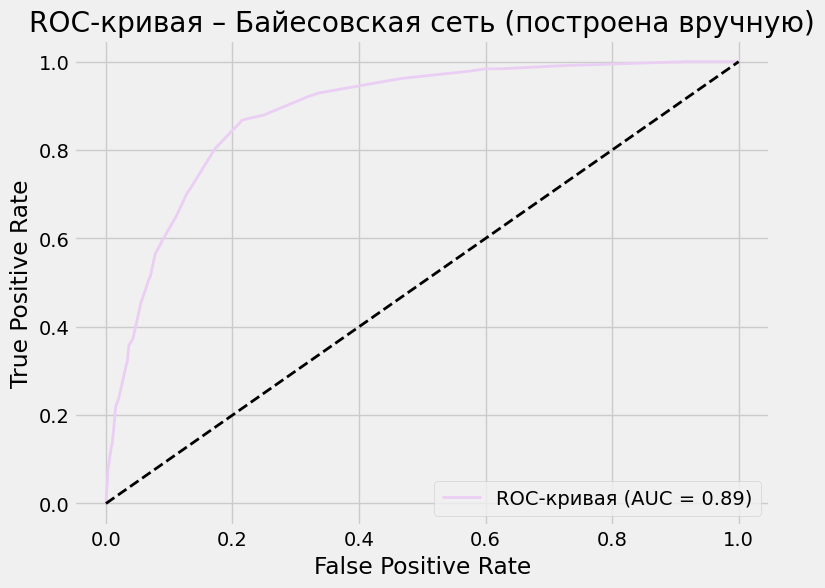

In [52]:
# задаем истинные значения (из тестовой выборки)
y_true = y_test_BN.astype(float).values

# считаем вероятность принадлежности к классу: если stress = 1, то вероятность p, если 0 – то (1 - p)
y_scores = predict_result_BN['p'].astype(float).where(predict_result_BN['stress'].astype(float) == 1, 1 - predict_result_BN['p'].astype(float))
fpr_BN, tpr_BN, _ = roc_curve(y_true, y_scores) # считаем FPR и TPR на основе истинных значений и вероятности
roc_auc_BN = auc(fpr_BN, tpr_BN) # считаем площадь под кривой

# строим график
plt.figure(figsize=(8,6))
plt.plot(fpr_BN, tpr_BN, color='#ebcef4', lw=2, label=f'ROC-кривая (AUC = {roc_auc_BN:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая – Байесовская сеть (построена вручную)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Теперь повторим то же самое, но для сети с автоматически настроенными связями.

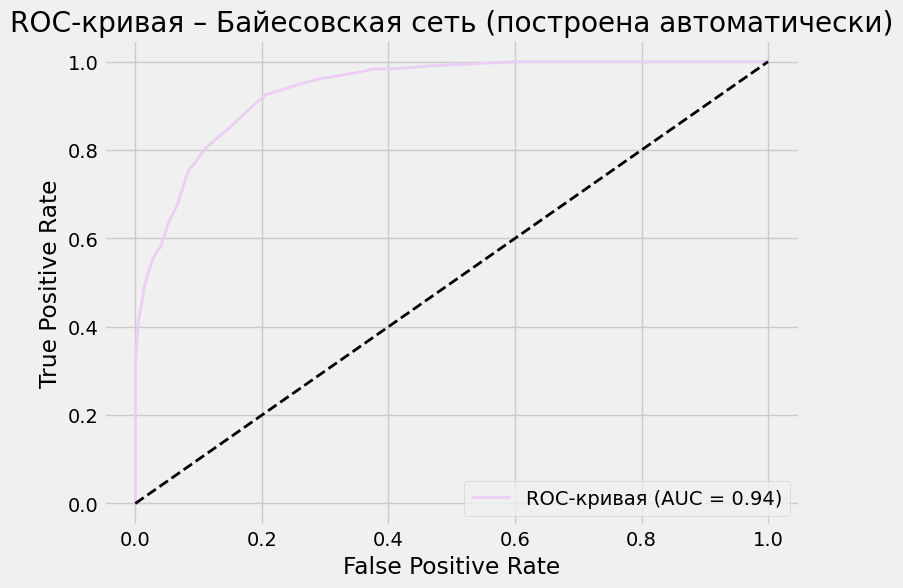

In [53]:
# считаем вероятность принадлежности к классу: если stress = 1, то вероятность p, если 0 – то (1 - p)
y_scores_auto = predict_result_auto['p'].astype(float).where(predict_result_auto['stress'].astype(float) == 1, 1 - predict_result_auto['p'].astype(float))
fpr_BN_auto, tpr_BN_auto, _ = roc_curve(y_true, y_scores_auto) # считаем FPR и TPR на основе истинных значений и вероятности
roc_auc_BN_auto = auc(fpr_BN_auto, tpr_BN_auto) # считаем площадь под кривой

# строим график
plt.figure(figsize=(8,6))
plt.plot(fpr_BN_auto, tpr_BN_auto, color='#ebcef4', lw=2, label=f'ROC-кривая (AUC = {roc_auc_BN_auto:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая – Байесовская сеть (построена автоматически)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Как видно из графиков, Байесовская сеть показывает хорошую способность различать положительные и отрицательные классы. Настроенная вручную сеть близак по AUC к случайному лесу и логистической регрессии, а настроенная автоматически – приближается к лучшей модели (градиентному бустингу).

### №3.8

Как мы писали в пункте 3.4, разумным критерием будет F1 – он позволит учесть значимость всех видов прогнозов.

Мы рассмотрели следующие модели – со случайными параметрами (3.2), с подбором параметров при помощи Accuracy (3.3), с подбором параметров случайного леса при помощи OOB-ошибок (3.3, повышенная сложность), с подбором при помощи Recall (3.4), с подбором при помощи кастомной метрики (но это привело к тем же результатам, что Accuracy), подбор при помощи цен прогнозов (но в модели использовались те же параметры, что и в Accuracy), Байесовская сеть (ручная и подобранная автоматически).

Таким образом, нам нужно сравнить F1 метрику у 5 базовых моделей (случайные параметры, параметры Accuracy, OOB-ошибки, параметры Recall) и для двух Байесовских сетей.

Начнем с базовых моделей.

In [54]:
# создаем словарь со всеми моделями
model_groups = {
    "Базовая модель": models,
    "Оптимизация Accuracy (и кастомной метрики)": best_models_acc,
    "Оптимизация OOB-ошибок (для случайного леса)": best_models_oob,
    "Оптимизация Recall": best_models_recall}

In [55]:
# создаем массив для результатов
results_models = []

# перебираем все модели
for group_name, model_dict in model_groups.items():
    for model_name, model in model_dict.items():
        # для каждой модели обучаем её
        model.fit(x_train, y_train)
        # получаем предсказания
        y_pred = model.predict(x_test)
        # рассчитываем f1-метрику
        f1 = f1_score(y_test, y_pred)
        # добавляем результаты в массив
        results_models.append({'Model Group': group_name, 'Model Name': model_name, 'F1 Score': f1})

In [56]:
# создаем датафрейм
df_results_models = pd.DataFrame(results_models)
df_results_models

,Model Group,Model Name,F1 Score
0,Базовая модель,Naive Bayes,0.786608
1,Базовая модель,KNN,0.504021
2,Базовая модель,Random Forest,0.829016
3,Базовая модель,Gradient Boosting,0.851211
4,Базовая модель,Logistic Regression,0.834441
5,Оптимизация Accuracy (и кастомной метрики),Naive Bayes,0.786608
6,Оптимизация Accuracy (и кастомной метрики),KNN,0.517082
7,Оптимизация Accuracy (и кастомной метрики),Random Forest,0.853372
8,Оптимизация Accuracy (и кастомной метрики),Gradient Boosting,0.851211
9,Оптимизация Accuracy (и кастомной метрики),Logistic Regression,0.833382


In [57]:
# создаем сводную таблицу, чтобы удобнее смотреть на результаты
df_results_models = df_results_models.pivot(index='Model Name', columns='Model Group', values='F1 Score')
df_results_models = df_results_models.reindex(columns=['Базовая модель', 'Оптимизация Accuracy (и кастомной метрики)', 'Оптимизация OOB-ошибок (для случайного леса)', 'Оптимизация Recall'])
df_results_models


Model Group,Базовая модель,Оптимизация Accuracy (и кастомной метрики),Оптимизация OOB-ошибок (для случайного леса),Оптимизация Recall
Model Name,,,,
Gradient Boosting,0.851211,0.851211,0.851211,0.851211
KNN,0.504021,0.517082,0.517082,0.517082
Logistic Regression,0.834441,0.833382,0.833382,0.834441
Naive Bayes,0.786608,0.786608,0.786608,0.786608
Random Forest,0.829016,0.853372,0.845998,0.850845


Для базовых моделей худшим классификатором по F1 метрике всегда является **KNN**, а наилучшим – **Random Forest при оптимизации Accuracy**. В остальных моделях лучшим классификатором является градиентный бустинг.

Теперь рассмотрим Байесовские сети.

In [58]:
# для настроенной вручную Байесовской сети
f1_BN = f1_score(y_true, y_pred_BN.astype(float))
f1_BN

0.8017266187050359

In [59]:
# для настроенной автоматически Байесовской сети
f1_BN_auto = f1_score(y_true, y_pred_auto.astype(float))
f1_BN_auto

0.8401486988847584

У автоматически настроенной Байесовской сети F1 выше, но она всё равно проигрывает случайному лесу и градиентному бустингу. Таким образом, лучшая модель согласно F1– случайный лес с параметрами оптимизации при помощи Accuracy.

### №3.9 (повышенная сложность)

Как мы помним из пункта 3.8, градиентный бустинг был лучшей моделью на протяжении всего исследования, однако именно при использовании F1 метрики уступил лидерство случайному лесу. Попробуем улучшить модель с помощью CatBoost. Это разработанный Yandex метод градиентного бустинга, который хорошо подходит для категориальных данных. В отличие от обычной модели, здесь используетя техника "упорядоченного бустинга", что снижает риск переобучения модели. Главное преимущество – это обработка категориальных признаков. Модель сама статистически преобразовывает переменные, не нужно дополнительно использовать one-hot encoding или другие способы преобразования. Другая особенность – симметрическое построение деревьев (если на одном уровне узел разбивается по признаку, то у "соседа" будет тот же шаблон). Это ускоряет работу кода.

In [60]:
# создаем базовую модель
Catboost_model = CatBoostClassifier(verbose=0, random_seed=141, task_type="CPU")

# задаем параметры для перебора
param_grid_catboost = {
    'iterations': [200, 500, 1000], # количество деревьев, которые будут построены
    'depth': [4, 6, 8], # максимальная глубина каждого дерева
    'learning_rate': [0.03, 0.1], # скорость обучения
    'l2_leaf_reg': [1, 3, 5], # L2-регуляризация на веса листьев
    'border_count': [32, 64]} # количество бинов при разбиении числовых признаков

# с помощью стандартного GridsearchCV перебираем параметры
grid_search_catboost = GridSearchCV(
    estimator=Catboost_model,
    param_grid=param_grid_catboost,
    scoring='f1', # метрика – f1
    cv=3,
    n_jobs=-1,
    verbose=2)

# обучаем модель
grid_search_catboost.fit(x_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x7e2cd4518f10>,
             n_jobs=-1,
             param_grid={'border_count': [32, 64], 'depth': [4, 6, 8],
                         'iterations': [200, 500, 1000],
                         'l2_leaf_reg': [1, 3, 5],
                         'learning_rate': [0.03, 0.1]},
             scoring='f1', verbose=2)

In [61]:
print("Best Params Catboost:", grid_search_catboost.best_params_) # выводим лучшие параметры
print("Test F1:", f1_score(y_test, grid_search_catboost.predict(x_test))) # рассчитываем f1 на тестовой выборке
print("Test Accuracy:", accuracy_score(y_test, grid_search_catboost.predict(x_test))) # выводим точность на тестовой выборке

Best Params Catboost: {'border_count': 64, 'depth': 4, 'iterations': 200, 'l2_leaf_reg': 3, 'learning_rate': 0.03}
Test F1: 0.8542657342657343
Test Accuracy: 0.8610666666666666


Таким образом, мы получили значение f1 выше, чем для лучшего классификатора (случайный лес с подбором параметров при помощи Accuracy). Сейчас лучшей моделью будет именно CatBoost с подбором параметров при помощи f1. Точность модели также оказалась высокой.

Преимущества метода:

*   **Обработка категориальных признаков** – метод автоматически работает с категориальными признаками, не нужно дополнительного перекодирования;
*   **Борьба с переобучением** – "упорядоченный бустинг" (каждое дерево строится так, будто не имеет информации о будущих данных) позволяет избежать переобучения на обучающей выборке;
*   **Скорость** – симметричное построение деревьев позволяет ускорять работу кода.

Недостатки метода:

*   **Время обучения** – модель обучается дольше, чем классические инструменты (в нашем случае обучение шло больше 10 минут);
*   **Возможности для вариантивности** – из-за автоматической обработки признаков меньше возможностей для контроля за разбиением;
*   **Небольшое количество документации**.

Вывод: предложенный метод хорошо подходит для автоматической работы с категориальными переменными, в нашем случае он подобрал лучшую модель согласно критерию F1, однако очень сильно замедлил работу кода.

### №3.10

При исследовании мы использовали Наивный Байесовский классификатор, предполагающий нормальное (или похожее на него) распределение переменных, и если непрерывные переменные (возраст и доход) действительно близки к Гауссовскому распределению, то бинарные – нет. Существуют и другие функции классификаторов, предназначенные для признаков разных типов данных. При построении Байесовской сети мы уже делили непрерывные переменные на категории. Попробуем применить это разделение для Наивного классификатора и сравним точность с классификатором для непрерывных переменных.

При классификации для Байесовской сети мы делили переменные на категории по названиям. Для Наивного Байесовского классификатора категории должны быть представлены целыми числами, поэтому нужно перекодировать некоторые переменные.

In [62]:
# задаем порядок для возраста и дохода
age_order = ['молодой', 'средний', 'взрослый', 'пожилой']
income_order = ['низкий', 'средний-', 'средний+', 'высокий']

In [63]:
encoder_X = OrdinalEncoder(categories=[age_order, income_order], dtype=int) # перекодируем переменные согласно установленному порядку
x_encoded = encoder_X.fit_transform(x_copy[['age', 'income']]) # меняем данные в датасете с категориальными переменными

In [64]:
# объединяем два перекодированных столба с остальными столбцами X
x_processed = pd.DataFrame(data=x_encoded, columns=['age', 'income']).join(x_copy[['gender', 'city', 'depressive', 'boss']])
x_processed = x_processed.astype(float).astype(int) # делаем все переменные целочисленными
x_processed

,age,income,gender,city,depressive,boss
0,2,2,0,1,5,1
1,2,3,0,1,5,1
2,1,1,1,1,2,0
3,2,3,1,1,2,1
4,1,0,0,1,1,1
...,...,...,...,...,...,...
14995,2,1,0,1,6,1
14996,3,3,1,1,4,1
14997,1,1,0,1,4,1
14998,2,3,1,1,1,0


In [65]:
# делим выборку нового датасета на обучающую и тестовую
x_train_CNB, x_test_CNB, y_train_CNB, y_test_CNB = train_test_split(x_processed, y, test_size=0.25, random_state=141)

In [66]:
categorical_NB = CategoricalNB(force_alpha = True, alpha = 0) # обозначаем модель
categorical_NB.fit(x_train_CNB, y_train_CNB) # обучаем модель
categorical_NB_test_acc = categorical_NB.score(x_test_CNB, y_test_CNB) # рассчитываем точность на тестовой выборке
categorical_NB_CV_acc = np.mean(cross_val_score(estimator = categorical_NB, X = x_train_CNB, y = y_train_CNB, cv = 5)) # рассчитываем точность при кросс-валидации

print("Точность категориального классификатора на тестовой выборке:", categorical_NB_test_acc)
print("Точность категориального классификатора при кросс-валидации:", categorical_NB_CV_acc)

Точность категориального классификатора на тестовой выборке: 0.8138666666666666
Точность категориального классификатора при кросс-валидации: 0.8225777777777777


Вывод: точность классификатора немного возросла по сравнению с классификатором для непрерывных переменных. Это может быть связано с тем, что при непрерывных значениях на обработку подается слишком много данных, что снижает точность.

Попробуем подобрать также лучшее значение альфы (параметр сглаживания Лапласа).

In [67]:
# создаем массив с перебираемыми значениями альф
alphas = [0, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]

# создаем словарь для результатов
results_alphas = {'alpha': [], 'test_accuracy': [], 'cv_accuracy': []}

# перебираем значения
for alpha in alphas:
    # создаем модель
    model = CategoricalNB(alpha=alpha, force_alpha=True)
    # обучаем модель на обучающей выборке
    model.fit(x_train_CNB, y_train_CNB)
    # рассчитываем точность на тестовой выборке
    test_acc = model.score(x_test_CNB, y_test_CNB)
    # рассчитываем точность при кросс-валидации
    cv_acc = np.mean(cross_val_score(model, x_train_CNB, y_train_CNB, cv=5))
    # добавляем результаты
    results_alphas['alpha'].append(alpha)
    results_alphas['test_accuracy'].append(test_acc)
    results_alphas['cv_accuracy'].append(cv_acc)

# создаем датафрейм с результатами
results_alphas_df = pd.DataFrame(results_alphas)
# сортируем результаты по значению на кросс-валидации
results_alphas_df = results_alphas_df.sort_values(by='cv_accuracy', ascending=False)
results_alphas_df

,alpha,test_accuracy,cv_accuracy
2,0.5,0.813867,0.822667
0,0.0,0.813867,0.822578
1,0.1,0.813867,0.822578
4,2.0,0.813600,0.822578
3,1.0,0.813600,0.822489
6,10.0,0.813867,0.822311
5,5.0,0.813333,0.821778


Лучшим по точности и на тестовой выборке и при кросс-валидации оказалось значение альфы, равное 0.5.

# Регрессия

### №4.1

Наша целевая переменная – потребление алкоголя в граммах чистого спирта (в месяц). Для ее прогнозирования мы выберем следующие признаки:


*   **Пол** – эмпирически показано, что мужчины потребляют алкоголь чаще женщин;
*   **Возраст** – чем старше человек, чем больше благ ему доступно и тем больше в его жизни может быть жизненных потрясений, влияющих на потребление алкоголя;
*   **Доход** – у людей с высоким уровнем дохода может быть доступ к иным развлечениям, помимо алкоголя;
*   **Проживание в городе** – отрицательно влияет на потребление алкоголя, так как есть доступ к иным видам досуга (в отличие от села, где доступ может быть ограничен);
*   **Склонность к депрессии** – человек в депрессивном состоянии может уменьшать свою апатию при помощи алкоголя;
*   **Руководящая должность** – в руководстве важную роль играют связи, которые в том числе образуются благодаря регулярному потреблению алкоголя;
*   **Наличие скидок в ближайшем магазине** – часть людей потребляет алкоголь не постоянно, а ситуативно. Для них фактором будут не только индивидуальные особенности, но и ситуативные факторы, такие как цена на алкоголь. При большом количестве скидок в ближайшем магазине человек может чаще потреблять алкоголь в течение месяца.

Таким образом, в регрессионный анализ мы включаем все переменные, кроме переменной воздействия (наличие стресса).



In [68]:
df

,gender,age,income,stress,city,depressive,boss,discounts,alcohol
0,0,45.0,54947.0,1.0,1,5.0,1,157.0,547.924271
1,0,60.0,67392.0,1.0,1,5.0,1,51.0,558.516383
2,1,34.0,52200.0,1.0,1,2.0,0,151.0,492.424415
3,1,57.0,63870.0,1.0,1,2.0,1,264.0,723.525197
4,0,37.0,45803.0,1.0,1,1.0,1,236.0,455.145156
...,...,...,...,...,...,...,...,...,...
14995,0,45.0,52358.0,1.0,1,6.0,1,74.0,587.368864
14996,1,73.0,73173.0,1.0,1,4.0,1,155.0,843.913570
14997,0,33.0,47682.0,1.0,1,4.0,1,248.0,463.877744
14998,1,54.0,62810.0,0.0,1,1.0,0,127.0,348.095032


In [69]:
x_reg = df[['gender', 'age', 'income', 'boss', 'city', 'depressive', 'discounts']]
y_reg = df['alcohol']

# делим выборку на обучающую и тестовую
x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x_reg, y_reg, test_size=0.25, random_state=141)

### №4.2

In [70]:
# создаем модели со случайными параметрами
models_reg = {
    "Linear Regression": LinearRegression(),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=141),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=141)
}

results_reg = []

for name, model in models_reg.items():
    # обучаем модели на обучающей выборке
    model.fit(x_train_reg, y_train_reg)
    # делаем предсказания
    y_train_reg_pred = model.predict(x_train_reg)
    y_test_reg_pred = model.predict(x_test_reg)

    # расчет метрик
    # RMSE
    train_reg_rmse = np.sqrt(mean_squared_error(y_train_reg, y_train_reg_pred)) # среднеквадратичная ошибка на обучающей выборке
    test_reg_rmse = np.sqrt(mean_squared_error(y_test_reg, y_test_reg_pred)) # среднеквадратичная ошибка на тестовой выборке
    cv_scores_reg = -cross_val_score(model, x_train_reg, y_train_reg, scoring='neg_root_mean_squared_error', cv=5) # параметр – отрицательный RMSE, так как мы хотим его минимизировать
    cv_rmse_reg = np.mean(cv_scores_reg) # рассчитываем среднее значение
    # MAPE
    train_reg_mape = mean_absolute_percentage_error(y_train_reg, y_train_reg_pred) # средняя абсолютная ошибка на обучающей выборке
    test__reg_mape = mean_absolute_percentage_error(y_test_reg, y_test_reg_pred) # средняя абсолютная ошибка на тестовой выборке
    mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False) # задаем значение MAPE как критерий
    cv_mape_reg = -np.mean(cross_val_score(model, x_train_reg, y_train_reg, scoring=mape_scorer, cv=5))
    # добавляем результаты в таблицу
    results_reg.append([name, train_reg_rmse, test_reg_rmse, cv_rmse_reg, train_reg_mape, test__reg_mape, cv_mape_reg])

# создаем дата-фрейм с результатами
df_results_reg = pd.DataFrame(results_reg, columns=["Model", "Train RMSE", "Test RMSE", "CV RMSE", "Train MAPE", "Test MAPE", "CV MAPE"])
df_results_reg

,Model,Train RMSE,Test RMSE,CV RMSE,Train MAPE,Test MAPE,CV MAPE
0,Linear Regression,153.790776,151.444812,153.921562,0.224310,0.214253,0.224621
1,KNN,317.003665,385.093571,389.333040,0.448988,0.532397,0.560040
2,Random Forest,36.572338,97.381163,97.711556,0.041156,0.102991,0.112002
3,Gradient Boosting,95.729353,98.061354,98.669137,0.126172,0.122120,0.129752


Интерпретация результатов:

*   Линейная регрессия показывает устойчивость в результатах на различных выборках, однако меньшую точность по сравнению с градиентным бустингом. MAPE подтверждает слабую точность. Это может быть связано с нелинейными связями, которые были созданы при генерации данных;
*   Как и при задачах классификации, хуже всего справляется метод k-ближайших соседей. Помимо самых больших ошибок на всех выборках, модель демонстрирует явное переобучение (большая разница в RMSE на обучающей и тестовой выборке). Для улучшения работы нужно менять число соседей, но скорее всего неточность связана с разным масштабом переменных;
*   Случайный лес оказался самой точной моделью, однако пока присутствует переобучение (RMSE 36.57 на обучающей выборке и 97.38 на тестовой). При подборе параметров можно улучшить модель;
*   Градиентный бустинг хоть и показывает меньшую точность, чем случайный лес, является более стабильной моделью (почти нет разницы при использовании разных выборок). При подборе гиперпараметров можно ожидать дополнительное уменьшение ошибок.

Пока лучшей моделью является случайный лес, но явно возможны улучшения.

### №4.3

Перейдем к тюнингу моделей.

In [71]:
# создаем словарь с параметрами для перебора
# у линейной регрессии нет параметров, так как регуляризация будет отдельно рассмотрена в пункте 4.6
param_grid_reg = {
    "KNN": {"n_neighbors": [3, 5, 7, 9]},
    "Random Forest": {"n_estimators": [50, 100, 150], "max_depth": [None, 5, 10]},
    "Gradient Boosting": {"n_estimators": [50, 100, 150], "learning_rate": [0.01, 0.1, 0.2]}}

results_tuned_reg = []

# цикл для подбора параметров
for name, model in models_reg.items():
    if name in param_grid_reg:  # есть параметры для подбора
        grid = GridSearchCV(model, param_grid_reg[name], cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1) #задаем поиск через RMSE
        grid.fit(x_train_reg, y_train_reg)
        best_model = grid.best_estimator_
        tuned_params = grid.best_params_
    else:  # если нет параметров
        model.fit(x_train_reg, y_train_reg)
        best_model = model
        tuned_params = "N/A"

    # расчет метрик
    tuned_train_rmse = np.sqrt(mean_squared_error(y_train_reg, best_model.predict(x_train_reg))) # расчет RMSE на обучающей выборке
    tuned_test_rmse = np.sqrt(mean_squared_error(y_test_reg, best_model.predict(x_test_reg))) # расчет RMSE на тестовой выборке
    tuned_cv_rmse = -np.mean(cross_val_score(best_model, x_train_reg, y_train_reg, cv=5, scoring='neg_root_mean_squared_error')) # расчет RMSE при кросс-валидации
    # добавляем результаты по моделям в таблицу
    results_tuned_reg.append([name, tuned_params, tuned_train_rmse, tuned_test_rmse, tuned_cv_rmse])

# создаем дата-фрейм
df_tuned_reg = pd.DataFrame(results_tuned_reg, columns=["Model", "Best Params", "Train RMSE", "Test RMSE", "CV RMSE"])
df_tuned_reg

,Model,Best Params,Train RMSE,Test RMSE,CV RMSE
0,Linear Regression,N/A,153.790776,151.444812,153.921562
1,KNN,{'n_neighbors': 9},335.046842,374.899844,375.011058
2,Random Forest,"{'max_depth': None, 'n_estimators': 150}",36.299782,97.014154,97.630440
3,Gradient Boosting,"{'learning_rate': 0.2, 'n_estimators': 150}",88.838355,94.944399,95.540200


In [72]:
# объединяем таблицы с метриками до подбора параметров
df_final_reg = df_results_reg.merge(df_tuned_reg, on="Model", how="inner", suffixes=('_Init', '_Tuned'))
df_final_reg = df_final_reg.drop(['Train MAPE', 'Test MAPE'], axis = 1) # убираем столбцы с MAPE

# добавляем столбец с изначальными параметрами
initial_params_reg = {
    "Linear Regression": "N/A (невозможно настроить)",
    "KNN": "{'n_neighbors': 5}",
    "Random Forest": "{'max_depth': None, 'n_estimators': 100}",
    "Gradient Boosting": "{'learning_rate': None, 'n_estimators': 100}"}

df_final_reg['Initial Params'] = df_final_reg['Model'].map(initial_params_reg)
# определяем последовательность столбцов
df_final_reg = df_final_reg[['Model', 'Initial Params', 'Train RMSE_Init', 'Test RMSE_Init', 'CV RMSE_Init', 'Best Params', 'Train RMSE_Tuned','Test RMSE_Tuned', 'CV RMSE_Tuned']]
df_final_reg

,Model,Initial Params,Train RMSE_Init,Test RMSE_Init,CV RMSE_Init,Best Params,Train RMSE_Tuned,Test RMSE_Tuned,CV RMSE_Tuned
0,Linear Regression,N/A (невозможно настроить),153.790776,151.444812,153.921562,N/A,153.790776,151.444812,153.921562
1,KNN,{'n_neighbors': 5},317.003665,385.093571,389.333040,{'n_neighbors': 9},335.046842,374.899844,375.011058
2,Random Forest,"{'max_depth': None, 'n_estimators': 100}",36.572338,97.381163,97.711556,"{'max_depth': None, 'n_estimators': 150}",36.299782,97.014154,97.630440
3,Gradient Boosting,"{'learning_rate': None, 'n_estimators': 100}",95.729353,98.061354,98.669137,"{'learning_rate': 0.2, 'n_estimators': 150}",88.838355,94.944399,95.540200


Интерпретация результатов:

*   Линейная регрессия не изменилась, так как не было параметров;
*   В KNN увеличилось число соседей, однако это не помогло значительно улучшить модель. Немного снизилось значение RMSE на тестовой выборке и при кросс-валидации, но увеличилось на обучающей. Это значит, что модель стала меньше переобучаться. Из-за сохранившихся высоких значений ошибок можно предположить, что проблема модели не в гиперпараметрах, а в изначальных данных;
*   Метрики для случайного леса лишь немного снизились, однако у нас не получилось избавиться от переобучения. Важно отметить, что при подборе параметров не была ограничена глубина деревьев. Возможно, от переобучения помогло бы избавиться введение большего числа параметров (а не только max_depth и n_estimators);
*   В градиентом бустинге улучшились все метрики – в частности, снизилась ошибка на тестовой выборке и при кросс-валидации, обгоняя показатели для случайного леса.

После тюнинга гиперпараметров наиболее точной моделью стал градиентный бустинг.

**Повышенная сложность**: подбор гиперпараметров градиентного бустинга через OOB ошибки. После обучения модели также как и для случайного леса можно рассчитать OOB-score, однако это применимо только в случае стохастического градиентного бустинга. При таком методе дерево обучается не на всей выборке, а на случайной части, благодаря чему и формируются oob-наблюдения. Чтобы получить oob-score, в параметрах модели нужно ограничить долю подвыборок (параметр subsamples), чтобы она было меньше 1.

In [76]:
# задаем параметры для перебора
params_reg_oob = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.5, 0.7, 0.9], # меньше 1 для стохастического градиентного бустинга
    'min_samples_leaf': [3, 5, 10]}

param_combinations_reg_oob = product(*params_reg_oob.values())

results_oob_reg = []

# делаем перебор параметров
for n_est, depth, lr, subsample, leaf in param_combinations_reg_oob:
    gb_reg = GradientBoostingRegressor(
        n_estimators=n_est,
        max_depth=depth,
        learning_rate=lr,
        subsample=subsample,
        min_samples_leaf=leaf,
        loss='squared_error',
        random_state=141)
    gb_reg.fit(x_train_reg, y_train_reg) # обучаем модель на обучающей выборке
    oob_score_reg = gb_reg.oob_score_ # рассчитываем oob-score
    rmse_test_oob = np.sqrt(mean_squared_error(y_test_reg, gb_reg.predict(x_test_reg))) # рассчитываем RMSE на тестовой выборке
    results_oob_reg.append([n_est, depth, lr, subsample, leaf, rmse_test_oob, oob_score_reg])

# создаем датафрейм
df_oob_reg = pd.DataFrame(results_oob_reg, columns = ['n_estimators','max_depth', 'learning_rate', 'subsample', 'min_samples_leaf', 'Test RMSE', 'OOB-score'])
# сортируем датафрейм по значению oob
df_oob_reg = df_oob_reg.sort_values('OOB-score', ascending = False)
df_oob_reg.head(5)

,n_estimators,max_depth,learning_rate,subsample,min_samples_leaf,Test RMSE,OOB-score
6,50,3,0.05,0.9,3,126.892968,17815.467634
7,50,3,0.05,0.9,5,126.892968,17815.467634
8,50,3,0.05,0.9,10,126.892968,17815.467634
3,50,3,0.05,0.7,3,126.911394,17715.581339
4,50,3,0.05,0.7,5,126.911394,17715.581339


При подборе через oob_score мы получили меньшее количество деревьев (50 против 150) и более низкий вес каждого из них (0.05 против 0.2). Модель должна была получиться более устойчивой, но медленной. При этом тестовое значение RMSE выше чем значение при кросс-валидации как до, так и после тюнинга гиперпараметров.

Вывод: для наших данных кросс-валидация лучше подходит для подбора параметров градиентного бустинга, чем oob-ошибки.

### №4.4

Единственное значение, которое мы считали для всех моделей, было Test RMSE, поэтому именно его справедливо использовать для сравнения моделей.

Худшей моделью оказался KNN. Как до, так и после тюнинга гиперпараметров мы наблюдали самые высокие значения RMSE. Так как подбор гиперпараметров не исправил проблему, мы предполагаем, что модель не подходит из-за изначальных данных (разницы масштабов между переменными). Возможно, нормализация данных помогла бы улучшить предсказания.

Лучшей моделью можно назвать градиентный бустинг после тюнинга гиперпараметров (learning_rate = 0.2, n_estimators = 150). Он показывает не только наименьшее RMSE, но и устойчивость на разных выборках и отсутствие переобучения.

Важно отметить, что случайный лес, который показывал также хорошую точность и минимальное RMSE явно остался переобученным после тюнинга гиперпараметров. Попробуем исправить это в пункте 4.6 с помощью использования дополнительных параметров перебора.

### №4.5 (повышенная сложность)

В качестве дополнительного метода моделирования мы решили взять символическую регрессию. Эта модель хороша тем, что выводит конкретные формулы, описывающие взаимосвязь между переменными, то есть по итогу мы получим не просто точность, а интерпертируемое уравнение. Суть метода заключается в аналитическом подборе взаимосвязей между переменными при помощи базовых математических операций. Отбор происходит при помощи эволюционного алгоритма – задается случайная комбинация переменных и операторов и далее происходит отбор лучших согласно выбранной метрике и их комбинация. Также вводятся случайные мутации признаков и операторов. Процесс продолжается, пока не найдется достаточно точная формула.

In [ ]:
# для корректной работы кода необходимо
# 1. запустить !pip install pysr
# 2. перезапустить среду
# 3. запустить основную ячейку кода БЕЗ повтороной загрузки pysr
# 4. для повторного запуска нужно перезапустить среду и прогнать те же ячейки БЕЗ повторной загрузки pysr

In [77]:
# отдельно импортируем общие библиотеки
import os
import random
import numpy as np

# задаем зерно
SEED = 11
os.environ["JULIA_NUM_THREADS"] = "1"
os.environ["PYSR_SEED"] = str(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

random.seed(SEED)
np.random.seed(SEED)

# отдельно импортируем библиотеку с самой символической регрессией
from pysr import PySRRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd

# задаем модель
sr_model = PySRRegressor(
    niterations=50, # число итераций
    population_size=20, # максимальное кол-во уравнений, которые эволюционируют в каждой итерации
    binary_operators=["+", "*", "-", "/"], # бинарные операторы
    unary_operators=["exp", "log", "abs"], # унарные операторы
    complexity_of_operators={"+": 1, "*": 1, "-": 1, "/": 1, "exp": 1.5, "log": 1.5, "abs": 1}, # вес каждого оператора (сложные весят больше)
    complexity_of_variables=1, # вес переменных
    maxsize=25, # максимальный общий вес модели
    loss="L2DistLoss()", # минимизируем функцию потерь
    verbosity=1,
    procs=1,
    parallelism = "serial",
    random_state=SEED,
    deterministic=True)

# обучаем модель
sr_model.fit(x_train_reg, y_train_reg)

# рассчитываем метрики (проверки при кросс-валидации нет)
train_sr_rmse = np.sqrt(mean_squared_error(y_train_reg, sr_model.predict(x_train_reg)))
test_sr_rmse = np.sqrt(mean_squared_error(y_test_reg, sr_model.predict(x_test_reg)))

# сохраняем результаты
results_sr = [["Symbolic Regression", sr_model.get_best()["equation"], train_sr_rmse, test_sr_rmse]]
df_results_sr = pd.DataFrame(results_sr, columns=["Model", "Best Equation", "Train RMSE", "Test RMSE"])

[juliapkg] Found dependencies: /usr/local/lib/python3.11/dist-packages/juliapkg/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.11/dist-packages/pysr/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.11/dist-packages/juliacall/juliapkg.json
[juliapkg] Locating Julia =1.10.0, ^1.10.3
[juliapkg] Using Julia 1.10.9 at /usr/local/bin/julia
[juliapkg] Using Julia project at /root/.julia/environments/pyjuliapkg
[juliapkg] Writing Project.toml:
             [deps]
             SymbolicRegression = "8254be44-1295-4e6a-a16d-46603ac705cb"
             Serialization = "9e88b42a-f829-5b0c-bbe9-9e923198166b"
             PythonCall = "6099a3de-0909-46bc-b1f4-468b9a2dfc0d"
             OpenSSL_jll = "458c3c95-2e84-50aa-8efc-19380b2a3a95"
             [compat]
             SymbolicRegression = "~1.11"
             Serialization = "^1"
             PythonCall = "=0.9.25"
             OpenSSL_jll = "~3.0"
[juliapkg] Installing packages:
             import Pkg
    

Compiling Julia backend...
INFO:pysr.sr:Compiling Julia backend...
[ Info: Note: you are running with more than 10,000 datapoints. You should consider turning on batching (`options.batching`), and also if you need that many datapoints. Unless you have a large amount of noise (in which case you should smooth your dataset first), generally < 10,000 datapoints is enough to find a functional form.
[ Info: Started!



Expressions evaluated per second: 1.080e+04
Progress: 49 / 1550 total iterations (3.161%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           5.760e+05  0.000e+00  y = 8.2121
2           3.568e+05  4.297e-01  y = abs(discounts)
3           1.595e+05  7.707e-01  y = 133.74 / 0.25649
5           8.164e+04  3.273e-01  y = (age + 71.12) * depressive
7           4.928e+04  2.492e-01  y = ((age + 106.43) * depressive) + depressive
15          3.362e+04  4.709e-02  y = ((-14.178 - (depressive * -13.885)) * depressive) + ab...
                                      s(abs(discounts + (depressive - -185)))
19          3.275e+04  6.022e-03  y = (gender * 204.68) + (((discounts * abs((depressive * -...
                                      0.64002) + 1.1537)) + abs(age)) + (age - -131.37))
───────

[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.373e+05  0.000e+00  y = 670.58
3           5.041e+04  4.956e-01  y = depressive * 147.83
5           3.658e+04  1.577e-01  y = (gender + depressive) * 136.9
7           3.304e+04  4.874e-02  y = ((gender + boss) + depressive) * 129.28
9           2.981e+04  5.036e-02  y = (((gender + depressive) * depressive) / 0.081589) + 34...
                                      3.38
11          2.363e+04  1.150e-01  y = (gender * discounts) + (((depressive * 12.646) * depre...
                                      ssive) + 258.19)
12          2.363e+04  -0.000e+00  y = (discounts * gender) + (258.19 - ((depressive * -12.6...
                                       46) * abs(depressive)))
13          2.145e+04  9.467e-02  y = (discounts * gender) + ((((boss + depressive) * depres...
                                      sive) * 12.265) - -247.83

In [78]:
# убираем настройки широты
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
df_results_sr

,Model,Best Equation,Train RMSE,Test RMSE
0,Symbolic Regression,(depressive * (depressive * 12.65122)) + ((boss + 1.5873923) * ((gender * 145.71526) - -116.357796)),133.648843,132.179755


Итоговое уровнение имеет следующий вид:

$\text{Alcohol}_{i} = 12.65122 * \text{Depressive}_{i}^2 + (\text{Boss}_{i} + 1.5873923) * (145.71526 * \text{Gender}_{i} + 116.357796)$

Несмотря на то, что было разрешено использование более сложных функций, в итоговой формуле присутствуют только простые операторы (произведение, сложение). Это связано с ограничением на максимальную сложность кода, без которого итоговый результат может не получиться. Также были отобраны всего 3 переменные – Depressive, Boss и Gender. Если пол и склонность к депрессии и вправду имеют большую корреляцию с целевой переменной (у Depressive самое высокое значение – 0.83), то Boss, наоборот, имеет низкую корреляцию (0.05). В этом может проявляться несовершенство этого метода – частично подбор переменных и коэффициентов происходит через мутацию признаков.

При этом, RMSE на тестовой выборке получился достаточно высоким – 132.18. Среди остальных моделей это ближе всего к линейной регрессии. Это можно объяснить использованием малого числа переменных и отсутствием сложных функций, которые реально присутствовали при генерации. Однако по сравнению с обычной регрессией, у символической есть преимущества в виде автоматического подбора функциональной формы модели.

Преимущества метода:

*   **Интерпретируемость** – по итогу мы получаем формулу в явном виде, а не просто "черный ящик". Можно легко интерпретировать получившиеся коэффициентны и связи внутри модели;
*   **Контроль сложности** – благодаря возможности задавать веса переменным и операторам, а также создавать лимиты сложности, можно менять сложность формулы (насколько это позволяют вычислительные мощности);
*   **Выявление нестандартных взаимосвязей** – в модели можно получить необычное сочетание операторов и комбинаций переменных, которое не получилось бы придумать просто аналитическим путем;
*   **Гибкость формул** – модели не ограничены линейной или полиномиальной структурой, можно использовать абсолютно разные операторы (например, тригонометрические).

Недостатки:

*   **Время работы** – так как подбор идет эволюционно, он происходит очень медленно, а любое увеличение сложности (например, увеличение итераций или рост лимита maxsize) ведет к еще большему увеличению времени работы или вообще к остановке кода на середине итераций;
*   **Нестабильность результатов** – так как мы работаем с Julia, требуются дополнительные параметры для закрепления результатов (простой np.random.seed не подойдет);
*   **Выбор неподходящих переменных** – так как отчасти отбор переменных случайный, могут отбираться переменные со слабой корреляцией с таргетом или же получаться нелогичные сочетания переменных, которые потом сложно интерпретировать.

Вывод: модель хороша тем, что получается понятное, интерпретируемое уравнение, однако сочетние переменных получилось не самым логичным. Для относительно недолгой работы кода было установлено маленькое ограничение на сложность, из-за чего сложные операторы даже не попали в функцию. По итогу модель проиграла в точности прогноза базовым методам.

### №4.6

Начнем с подбора параметров для случайного леса. Ранее модель показывала признаки переобучения (очень низкая RMSE на обучающей выборке с высокими значениями на тестовой и кросс-валидационной выборках). Попробуем использовать больше параметров с использованием кросс-валидации.

In [73]:
# создаем словарь с параметрами, добавляя сюда больше факторов
param_grid_rf_reg = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 7, 10], # ограничили глубину деревьев
    'max_features': ['sqrt', 0.3, 0.5],
    'min_samples_leaf': [1, 3, 5, 10]}

# задаем модель
rf_model_reg = RandomForestRegressor(random_state=141)

# делаем поиск при помощи кросс-валидации, метрика - RMSE
grid_rf = GridSearchCV(rf_model_reg, param_grid_rf_reg, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_rf.fit(x_train_reg, y_train_reg) # обучаем модель на обучающей выборке
# выводим параметры для лучшей модели
best_rf = grid_rf.best_estimator_ #сама модель
best_params_rf = grid_rf.best_params_ # параметры

# расчет метрик
rf_tuned_train_rmse = np.sqrt(mean_squared_error(y_train_reg, best_rf.predict(x_train_reg))) # RMSE на обучающей выборке
rf_tuned_test_rmse = np.sqrt(mean_squared_error(y_test_reg, best_rf.predict(x_test_reg))) # RMSE на тестовой выборке
rf_tuned_cv_rmse = -np.mean(cross_val_score(best_rf, x_train_reg, y_train_reg, cv=5, scoring='neg_root_mean_squared_error')) # RMSE при кросс-валидации

# добавляем всё в датафрейм
df_rf_tuned = pd.DataFrame({'Model': ['Random Forest'], 'Best Params': [best_params_rf], 'Train RMSE': [rf_tuned_train_rmse], 'Test RMSE': [rf_tuned_test_rmse],'CV RMSE': [rf_tuned_cv_rmse]})

df_rf_tuned

,Model,Best Params,Train RMSE,Test RMSE,CV RMSE
0,Random Forest,"{'max_depth': 10, 'max_features': 0.5, 'min_samples_leaf': 1, 'n_estimators': 150}",79.045435,96.330917,98.603473


Интерпретация: как мы видим, добавление большего числа признаков и ограничение глубины деревьев действительно помогли. Обучающая выборка приблизилась к двум другим, а тестовая и кросс-валидационная продолжают показывать низкие значения. Если сравнивать с моделями из пункта 4.3, то градиентный бустинг всё равно немного лучше (по Test RMSE и CV RMSE). Однако текущий результат – не предел, так как полностью исключить переобучение всё равно не получилось. К сожалению, в исследовании мы ограничены в вычислительных мощностях, однако добавление большего числа параметров (или их значений) могло бы дополнительно улучшить модель.

Теперь вернемся к линейной регрессии. В исследовании мы не добавляли никакие параметры, однако для улучшения метрик можно использовать регуляризацию. Посмотрим, улучшит ли это модели.

In [74]:
# создаем набор перебираемых альф
alphas_reg = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]

# задаем модели с кросс-валидацией и классическую линейную регрессию
lin_reg_models = {
    "Lasso": LassoCV(alphas=alphas_reg, cv=5, max_iter=10000, random_state=141),
    "Ridge": RidgeCV(alphas=alphas_reg, cv=5),
    "Linear Regression": LinearRegression()}

results_tuned_lin_reg = [] # задаем массив для результатов

for name, model in lin_reg_models.items():
    # обучаем модель
    model.fit(x_train_reg, y_train_reg)
    # получаем лучшее значение альфа для моделей (если отсутствует, то N/A)
    best_alpha = getattr(model, 'alpha_', 'N/A')
    # рассчитываем метрики
    train_rmse = np.sqrt(mean_squared_error(y_train_reg, model.predict(x_train_reg)))
    test_rmse = np.sqrt(mean_squared_error(y_test_reg, model.predict(x_test_reg)))
    cv_rmse = - np.mean(cross_val_score(model, x_train_reg, y_train_reg, cv=5, scoring='neg_root_mean_squared_error'))

    results_tuned_lin_reg.append([name, best_alpha, train_rmse, test_rmse, cv_rmse])

# создаем датафрейм с результатами
df_tuned_lin_reg = pd.DataFrame(results_tuned_lin_reg, columns=["Model", "Best Alpha", "Train RMSE", "Test RMSE", "CV RMSE"])
df_tuned_lin_reg

,Model,Best Alpha,Train RMSE,Test RMSE,CV RMSE
0,Lasso,0.0001,153.790776,151.444789,153.921344
1,Ridge,0.0001,153.790776,151.444811,153.922439
2,Linear Regression,N/A,153.790776,151.444812,153.921562


Интерпретация: на текущих данных регуляризация не улучшила модель. Оптимальная альфа близка к 0, значит, признаки уже хорошо отобраны или в данных нет мультиколлинеарности. Попробуем масштабировать данные. Суть заключаются в том, что данные перекодируются – все признаки получают среднее значение 0 и стандартное отклонение 1.

In [75]:
# задаем масштабирование через Pipeline
lin_reg_models_scaled = {"Lasso": Pipeline([('scaler', StandardScaler()), ('model', LassoCV(alphas=alphas_reg, cv=5, random_state=141))]),
    "Ridge": Pipeline([('scaler', StandardScaler()), ('model', RidgeCV(alphas=alphas_reg, cv=5))]),
    "LinearRegression": Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())])}

results_tuned_lin_reg_scaled = []
for name, pipeline in lin_reg_models_scaled.items():
    # обучаем модель
    pipeline.fit(x_train_reg, y_train_reg)
    # выводим оптимальное значение альфы
    best_alpha = 'N/A'
    if name in ['Lasso', 'Ridge']:
        best_alpha = pipeline.named_steps['model'].alpha_

    # расчет метрик
    train_rmse = np.sqrt(mean_squared_error(y_train_reg, pipeline.predict(x_train_reg)))
    test_rmse = np.sqrt(mean_squared_error(y_test_reg, pipeline.predict(x_test_reg)))
    cv_rmse = -np.mean(cross_val_score(pipeline, x_train_reg, y_train_reg, cv=5, scoring='neg_root_mean_squared_error'))
    # добавляем результаты в таблицу
    results_tuned_lin_reg_scaled.append([name, best_alpha, train_rmse, test_rmse, cv_rmse])

# создаем датафрейм
df_tuned_lin_reg_scaled = pd.DataFrame(results_tuned_lin_reg_scaled, columns=["Model", "Best Alpha", "Train RMSE", "Test RMSE", "CV RMSE"])
df_tuned_lin_reg_scaled

,Model,Best Alpha,Train RMSE,Test RMSE,CV RMSE
0,Lasso,0.0001,153.790776,151.444793,153.921562
1,Ridge,5.0,153.790878,151.444164,153.920978
2,LinearRegression,N/A,153.790776,151.444812,153.921562


Интерпретация: масштабирование данных несильно помогло в регуляризации. Изменилась альфа в Ridge-модели, однако на RMSE это практически не отразилось. Это говорит о том, что либо признаки связаны с целевой переменной линейно (что точно неверно, так как при генерации использовались сложные функции), либо все отобранные переменные являются значимыми и действительно влияют на зависимую переменную (то есть мы не смогли обнулить незначимые переменные через регуляризацию).

# Эффекты воздействия

### №5.1

$\text{Y}_{i}(1)$ и $\text{Y}_{i}(0)$ – потенциальные исходы для индивида при наличии или отсутствии воздействия стресса. Тогда, наблюдаемое значение целевой переменной равно: $\text{Y}_{i} = \text{T}_{i} * \text{Y}_{i}(1) + (1 - \text{T}_{i}) * \text{Y}_{i}(0)$, где $\text{T}_{i} \in \{ 0, 1 \}$ – индикатор воздействия (был стресс или нет).

### №5.2

In [ ]:
# настоящие эффекты воздействия – разница в потреблении алкоголя между теми, у кого есть стресс, и у кого его нет
TE = alcohol1 - alcohol0
print(TE[0:10])

[ 64.73991453  52.35600276  93.67834237 315.48378404 202.04296111
  66.64775928 212.91203365 -56.0287921  199.63786349 183.13899773]


В реальности мы не можем посчитать эффект воздействия $\text{TE}_{i}$, поскольку не можем наблюдать одновременно оба потенциальных исхода: $\text{Y}_{0i}$ и $\text{Y}_{1i}$.

In [ ]:
# точный средний эффект воздействия, не наблюдаемый в реальных данных
ATE = np.mean(TE)
print(ATE)

220.7961467477756


Если бы у нас были данные о $\text{Alcohol}_{1i}$ и $\text{Alcohol}_{0i}$, то мы могли бы очень точно оценить $\text{ATE}$ как:

$$\widehat{\text{ATE}} = \frac{1}{n}\sum\limits_{i=1}^{n}\text{Alcohol}_{1i} - \text{Alcohol}_{0i}$$

Средний эффект воздействия:

$$\text{ATE} = \text{E}\left(\text{Alcohol}_{1i} - \text{Alcohol}_{0i}\right)$$

Интерпретация: если человек испытывает стресс, то его потребление алкоголя (в г чистого спирта) в месяц увеличится в среднем на 220.8 г.

In [ ]:
# точный локальный средний эффект воздействия, недоступный на реальных данных
LATE = np.mean(TE[compliers])
print(LATE)

192.29372405516236


Локальный средний эффект воздействия:

$$\text{LATE} = \text{E}(\text{Alcohol}_{1i} - \text{Alcohol}_{0i} | \text{Stress}_{1i} > \text{Stress}_{0i})$$

Без введения дополнительных строгих допущений, например, о том, что эффект воздействия $\text{T}_{i}$ на $\text{Y}_{i}$ является одинаковым для всех индивидов, в общем случае оценить ATE не получится, но можно оценить локальный средний эффект воздействия LATE, отражающий ATE среди соблюдателей. В контексте наших переменных, соблюдатели – это те люди, которые испытывают стресс, если находятся на руководящей должности, и не испытывают его, если не являются боссами.

Интерпретация: среди соблюдателей потребление алкоголя (в г чистого спирта) увеличится в среднем на 192.29 г при наличии стресса.

In [ ]:
# расчет условных средних эффектов воздействия, недоступный на реальных данных
CATE = g1 - g0
print(CATE[0:10])

[ 69.44131336  59.04070418  84.50854017 281.48383794   7.21475063
  98.14627176 181.38462779 -51.95319252 214.5389504  151.38461022]


Условный средний эффект воздействия считается как:

$$\text{CATE}_{i} = \text{E}\left(\text{Alcohol}_{1i}|X_{i}\right) - \text{E}\left(\text{Alcohol}_{0i}|X_{i}\right) = g_{1}(X_{i}) - g_{0}(X_{i})$$



CATE показывает, насколько в среднем изменится потребление алкоголя у людей с характеристиками $\text{X}_{i}$, если они подвергнутся воздействию – стрессу.

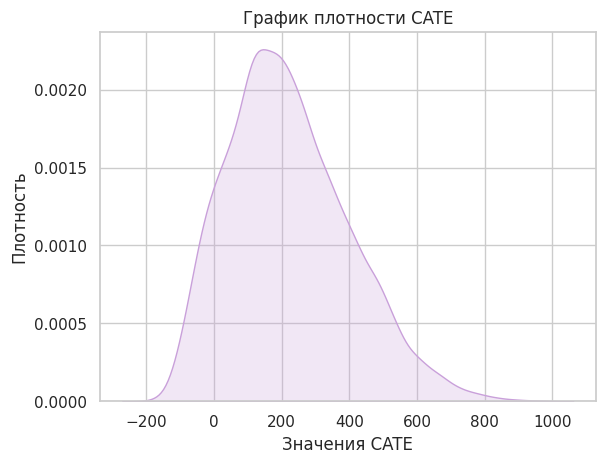

In [ ]:
# строим гистограмму плотности для CATE
sns.set(style="whitegrid")
sns.kdeplot(CATE, fill=True, color='#C9A0DA')
plt.title('График плотности CATE')
plt.xlabel('Значения CATE')
plt.ylabel('Плотность')
plt.show()

Для большинства наблюдений эффект положительный и сосредоточен в районе 200, однако есть отрицательные значения (индивиды, для которых стресс отрицательно влияет на потребление алкоголя) и достаточно большой правый хвост (для кого стресс повышает потребление алкоголя до 800-1000 грамм в месяц).

### №5.3

In [ ]:
# используем наивную оценку, как разницу выборочных средних
np.random.seed(141)
ATE_naive = np.mean(alcohol[stress == 1]) - np.mean(alcohol[stress == 0])

print(pd.DataFrame(data    = [ATE, ATE_naive], index   = ['ATE', 'ATE naive'], columns = ['Оценка']))

               Оценка
ATE        220.796147
ATE naive  445.306280


Попробуем оценить ATE наивным способом. Оценка опирается на допущение о независимости, которое в данном случае не соблюдается, поскольку другие признаки одновременно связаны и с наличием стресса $\text{Stress}_{i}$, и с потреблением алкоголя $\text{Alcohol}_{i}$ – на реальных данных наблюдается проблема *эндогенности*. Так как при генерации данных стресс зависел от других переменных, простая разница средних не отражает причинный эффект. Помимо этого, может происходить *самоотбор*, из-за которого попадание в группу стресса определяется не случайно, а связано с определенными характеристиками индивидов. Возможна и проблема *обратной зависимост*и – чрезмерное потребление алкоголя может влиять на личные и рабочие отношения, что повышает уровень стресса. Таким образом, из-за нарушения предпосылок о независимости наивная оценка оказывается смещенной.

Наивный подход предлагает оценивать $\text{ATE}$ как среднюю разницу в потреблении алкоголя людей при наличии и отсутствии стресса:
$$\widehat{\text{ATE}}_{\text{naive}} = \frac{1}{n_{1}}\sum\limits_{i:\text{Stress}_{i}=1}\text{Alcohol}_{i} - \frac{1}{n_{0}}\sum\limits_{i:\text{Stress}_{i}=0}\text{Alcohol}_{i}$$

Где $n_{1}$ и $n_{0}$ – количество людей со стрессом и без.


Можно увидеть, что предпосылка о независимости является очень сильной и дает неточный результат. Мы не можем использовать такую предпосылку при оценивании ATE, так как она соблюдается лишь в рамках контролируемых случайных экспериментов. В нашем случае, это неверно, потому что переменная воздействия Stress не назначается нами в случайном порядке, она зависит от различных переменных.

### №5.4

Попробуем оценить ATE при помощи различных классификационных и регрессионных моделей


*   Метод наименьших квадратов


In [ ]:
# средний эффект воздействия с помощью МНК – используем стандартную линейную регрессию
np.random.seed(141)

# МНК оценивание потребления алкоголя у индивидов без стресса
y0  = df.loc[stress == 0, ['alcohol']]
x0  = df.loc[stress == 0, df.columns.drop(['alcohol', 'boss', 'stress'])]
x0  = sm.add_constant(x0)
ls0 = sm.OLS(y0, x0).fit()

# МНК оценивание потребление алкоголя у индивидов со стрессом
y1  = df.loc[stress == 1, ['alcohol']]
x1  = df.loc[stress == 1, df.columns.drop(['alcohol', 'boss', 'stress'])]
x1  = sm.add_constant(x1)
ls1 = sm.OLS(y1, x1).fit()

# оценка потребления алкоголя при наличии и отсутствия стресса
x = df.loc[:, df.columns.drop(['alcohol', 'boss', 'stress'])]
x = sm.add_constant(x)
alcohol0_ls = ls0.predict(x)
alcohol1_ls = ls1.predict(x)

CATE_ls = np.array(alcohol1_ls - alcohol0_ls)

# оценка ATE как средняя разница в прогнозах МНК оценок
ATE_ls = np.mean(CATE_ls)
ATE_ls

215.80723486555615

In [ ]:
# сравнение результатов
print(pd.DataFrame(data    = [ATE, ATE_naive, ATE_ls], index   = ['ATE', 'ATE naive', "ATE ls"], columns = ['Оценка']))

               Оценка
ATE        220.796147
ATE naive  445.306280
ATE ls     215.807235


Ослабим допущение о независимости до допущения об условной независимости:

$$\text{E}(\text{Alcohol}_{1i}|\text{Stress}_{i}=1,X_{i}) = \text{E}(\text{Alcohol}_{1i}|X_{i})\qquad \text{E}(\text{Alcohol}_{0i}|\text{Stress}_{i}=0,X_{i}) = \text{E}(\text{Alcohol}_{0i}|X_{i})$$

Попробуем оценить $\text{ATE}$ рассмотрев среднюю разницу в оценках потребления алкоголя, полученных с помощью МНК отдельно сперва по индивидам со стрессом, а затем по индивидам без стресса.

$$\widehat{\text{ATE}}_{\text{LS}} = \frac{1}{n}\sum\limits_{i=1}^{n} \underbrace{\hat{\text{E}}\left(\text{Alcohol}_{1i}|X_{i}\right) - \hat{\text{E}}\left(\text{Alcohol}_{0i}|X_{i}\right)}_{\widehat{\text{CATE}}_{i}}$$

Интерпретация: видно, что предпосылка об условной независимости работает лучше, оценка ATE уже намного ближе к реальному показателю.

Ограничение: возможная эндогенность в переменных, например, что переживаемый стресс может в некоторой степени зависеть от количества алкоголя. Так как пока она не была учтена, оценка всё равно получилась неточной.


*   Условные математические ожидания


In [ ]:
# оценка с помощью условных мат ожиданий
np.random.seed(141)
y0 = df.loc[stress == 0, ['alcohol']]
x0 = df.loc[stress == 0, df.columns.drop(['alcohol', 'boss', 'stress'])]
x0 = sm.add_constant(x0)

y1 = df.loc[stress == 1, ['alcohol']]
x1 = df.loc[stress == 1, df.columns.drop(['alcohol', 'boss', 'stress'])]
x1 = sm.add_constant(x1)

x = df.loc[:, df.columns.drop(['alcohol', 'boss', 'stress'])]
x = sm.add_constant(x)

# берем градиентный бустинг с лучшими показателями на задачах регрессии
reg3 = GradientBoostingRegressor(**{'learning_rate': 0.2, 'n_estimators': 150})
reg3.fit(x0, y0)

alcohol0_reg3 = reg3.predict(x)

reg3.fit(x1, y1)

alcohol1_reg3 = reg3.predict(x)

CATE_T = alcohol1_reg3 - alcohol0_reg3

ATE_CM = np.mean(CATE_T)
print(ATE_CM)

221.4920886912826


$$\text{E}(\text{Alcohol}_{1i}|\text{Stress}_{i}=1,X_{i}) = \text{E}(\text{Alcohol}_{1i}|X_{i})\qquad $$

Мы используем ту же предпосылку об условной независимости, но пытаемся учесть нелинейной при помощи инструментов машинного обучения. Для этого мы использовали лучшую модель (по CV RMSE) среди всех регрессионных моделей – Градиентный бустинг с параметрами learning_rate = 0.2 и n_estimators = 150.

Интерпретация: благодаря использованию машинного обучения оценка стала еще ближе к истинному показателю, но небольшое смещение всё равно осталось. Это может быть связано с тем, что условные мат. ожидания $\text{E}(\text{Y}_{i}|\text{X}_{i}, \text{T}_{i})$ неизвестны, результаты во многом зависят от подобранной модели. Также могут присутствовать скрытые переменные, которые влияют и на стресс, и на потребление алкоголя.


*   Взвешивание на обратные условные вероятности


In [ ]:
# обратные условные вероятности
np.random.seed(141)
target = df.loc[:, ['stress']]
features = df.loc[:, df.columns.drop(['alcohol', 'boss', 'stress'])]

# выбираем лучшую классификационную модель по accuracy на кросс-валидационной выборке – градиентный бустинг
clf =  GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 100)
clf.fit(features, target)

prob_clf  = clf.predict_proba(features)[:, 1]

alcohol_pseudo = (alcohol * stress) / prob_clf  - (alcohol * (1 - stress)) / (1 - prob_clf)

ATE_IPW = np.mean(alcohol_pseudo)
print(ATE_IPW)

266.52878787460537


Оценка, получаемая с помощью взвешивания на обратные вероятности $\text{IPW}$, имеет вид:

$$\widehat{\text{ATE}}^{\text{IPW}} = \frac{1}{n}\sum\limits_{i=1}^{n}\frac{\text{Stress}_{i}\times\text{Alcohol}_{i}}{\hat{P}\left(\text{Stress}_{i}=1|X_{i}\right)} - \frac{\left(1 - \text{Stress}_{i}\right)\times\text{Alcohol}_{i}}{1 - \hat{P}\left(\text{Stress}_{i}=1|X_{i}\right)}$$

Где условные вероятности $\hat{P}\left(\text{Stress}_{i}=1|X_{i}\right)$ оценивались с помощью лучшей для наших данных моделью классификатора – GradientBoostingClassifier.
Как и раньше, оценка очень сильно зависит от выбранной модели. В нашем случае она получилась сильно смещенной, что говорит о том, что модель подобрана неверно.



*   Метод двойной устойчивости




In [ ]:
#двойная устойчивость
np.random.seed(141)
# используем лучший регрессор
reg = GradientBoostingRegressor(**{'learning_rate': 0.2, 'n_estimators': 150})

y = df.loc[:, ['alcohol']]
x = df.loc[:, df.columns.drop(['alcohol', 'boss'])]
x0 = deepcopy(x)
x0['stress'] = 0
x1 = deepcopy(x)
x1['stress'] = 1

reg.fit(x, y)

alcohol1_clf = reg.predict(x1)
alcohol0_clf = reg.predict(x0)

ATE_DR = np.mean((alcohol1_clf - alcohol0_clf) + \
                 stress * (alcohol - alcohol1_clf) / prob_clf - \
                 (1 - stress) * (alcohol - alcohol0_clf) / (1 - prob_clf))
print(ATE_DR)

203.49415540003434


Методом с двойной устойчивостью средний эффект воздействия оценивается как:

$$\widehat{\text{ATE}}^{\text{DR}} = \frac{1}{n}\sum\limits_{i=1}^{n}\hat{\text{E}}\left(\text{Alcohol}_{i}|X_{i}, T_{i}=1\right) - \hat{\text{E}}\left(\text{Alcohol}_{i}|X_{i}, T_{i}=0\right) + \frac{\text{Stress}_{i}\times\left(\text{Alcohol}_{i}-\hat{\text{E}}\left(\text{Alcohol}_{i}|X_{i}, T_{i}=1\right)\right)}{\hat{P}(\text{Stress}_{i}=1|X_{i})} - \frac{\left(1-\text{Stress}_{i}\right)\times\left(\text{Alcohol}_{i}-\hat{\text{E}}\left(\text{Alcohol}_{i}|X_{i}, T_{i}=0\right)\right)}{1 - \hat{P}(\text{Stress}_{i}=1|X_{i})}$$

Раньше мы использовали предпосылку об условной независимости, но в ней есть проблема: точность оценок каждого из этих способов зависит от точности оценок соответствующих условных математических ожиданий или вероятностей. Если они оценены неточно, то и итоговая оценка ATE также будет неточной.

Попробуем решить эту проблему: постараемся взять двойную устойчивость, то есть совместить оба способа, чтобы оценка ATE оказывалась состоятельной, если по крайней мере один из них дает состоятельную оценку. Однако если оба способа не состоятельны, то оценка всё равно может быть неточной.

Как видно из полученного значения, сейчас оценка смещена, то есть оба способа оценки несостоятельны.


*   Двойное машинное обучение


In [ ]:
np.random.seed(141)
# задаем данные в формате, подходящем для ДМО
dml_standard_data = dml.DoubleMLData(
                            data   = df,
                            y_col  = 'alcohol',
                            d_cols = 'stress',
                            x_cols = ['gender', 'age', 'income', 'city', 'depressive', 'discounts'])

# метод оценивания E(Y | X, T)
g_Y =GradientBoostingRegressor(learning_rate = 0.2, n_estimators = 150) # всё тот же лучший регрессор

# метод оценивания E(T | X)
g_T = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 100)

# подготовка объекта
dml_standard = dml.DoubleMLIRM(obj_dml_data = dml_standard_data,
                               ml_g         = g_Y,
                               ml_m         = g_T,
                               n_rep        = 1,
                               n_folds      = 5)

dml_standard.fit()
ATE_dml_standard = dml_standard.coef[0]
print(ATE_dml_standard)

220.71674136618196


Интерпретация: мы получили максимально точную модель, которая также обладает свойством двойной устойчивости. Благодаря двойному обучению модели снижается влияние факторов, которые оказывают воздействие и на алкоголь, и на стресс.


*   **Повышенная сложность**: метод PSM


In [ ]:
# повышенная сложность, доп. метод Propensity Score Matching (PSM)

stress = df['stress'].values
alcohol = df['alcohol'].values
X = df.drop(columns=['alcohol', 'boss', 'stress'])

# вероятности и матчинг
propensity_model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100)
propensity_model.fit(X, stress)
propensity_scores = propensity_model.predict_proba(X)[:, 1]  # P(T=1|X)

treated_indices = np.where(stress == 1)[0]
control_indices = np.where(stress == 0)[0]

# поиск ближайшего соседа
nbrs = NearestNeighbors(n_neighbors=1, metric='euclidean')
nbrs.fit(propensity_scores[control_indices].reshape(-1, 1))

distances, matched_control_indices = nbrs.kneighbors(propensity_scores[treated_indices].reshape(-1, 1))
matched_control_indices = control_indices[matched_control_indices.flatten()]

ATE_PSM = np.mean(alcohol[treated_indices] - alcohol[matched_control_indices])
print(ATE_PSM)

195.05192065453673


Опишем принцип работы PSM:

Сначала оценивается вероятность получения лечения для каждого наблюдения   $\text{E}(\text{X}_{i}) = \text{P}(\text{T}_{i} = 1 | \text{X}_{i})$
с помощью логистической регрессии или других классификаторов (мы использовали лучший градиентный бустинг).

Matching:
Для каждого обработанного наблюдения $\text{T}_{i} = 1$ подбирается "похожее" контрольное наблюдение $\text{T}_{i} = 0$ на основе близости propensity score. Это можно сделать, например, при помощи KNN.

После сопоставления, ATE вычисляется как разница средних исходов между обработанными и подобранными контрольными группами:

$$\widehat{\text{ATE}}_{\text{PSM}} = \frac{1}{n_{1}}\sum\limits_{i:\text{Stress}_{i}=1}(\text{Alcohol}_{i} - \text{Alcohol}_{j(i)})$$

где $\text{Alcohol}_{i}$ – исход индивида с $\text{T}_{i} = 1$, а $\text{Alcohol}_{j(i)}$ – исход наиболее похожего индивида с $\text{T}_{i} = 0$.

Преимущества метода:

*   **Интерпретируемость** – так как метод ищет соседей, происходит отбор, похожий на рандомизированный эксперимент, что проще поддается интерпретации, чем обычные методы машинного обучения;
*   **Гибкость** – можно выбрать любую метрику схожести для создания пар;

Недостатки метода:

*   **Зависимость от качества начальных оценок** – результаты сильно зависят от качества оценки propensity score, которая также может быть смещенной при неправильном выборе модели;
*   **Потеря наблюдений** – так как не всем наблюдениям может найтись пара, часть данных может потеряться
*   **Высокая дисперсия** – если в данных мало наблюдений или разделение на пары неточное, но оценка может сильно колебаться.

Вывод: PSM – это интуитивно понятный метод оценки ATE, который симулирует рандомизированный эксперимент. В нашем случае оценка сильно смещена, так как в методе нельзя учесть проблемы эндогенности и одновременного влияния нескольких переменных, что позволяют сделать другие методы машинного обучения.

In [ ]:
# выводим вместе все оценки
print(pd.DataFrame(data    = [ATE, ATE_naive, ATE_ls, ATE_CM, ATE_IPW, ATE_DR, ATE_dml_standard, ATE_PSM],
                   index   = ['ATE', 'ATE naive', 'ATE ls', 'ATE_CM', 'ATE_IPW', 'ATE_DR', 'ATE dml standard', 'ATE_PSM'],
                   columns = ['Оценка']))

                      Оценка
ATE               220.796147
ATE naive         445.306280
ATE ls            215.807235
ATE_CM            221.492089
ATE_IPW           266.528788
ATE_DR            203.494155
ATE dml standard  220.716741
ATE_PSM           195.051921


Выводы:


*   Оценка наивным методом самая завышенная, что указывает на сильнео смещение. Оно может быть связано с тем, что другие контрольные переменные влияют одновременно на стресс и алкоголь, что нарушает предпосылку о независимости;
*   Ближе всего к истинному значению оценка методом ДМО. Благодаря двойному обучению получилось как запрограммировать нелинейные связи, так и минимизировать влияние шумов и других контрольных переменных



### №5.5

В этом пункте мы оцениваем LATE при помощи ДМО с и без инструментальной переменной. Также из датасета исключается $\text{Depressive}_{i}$, что создает проблему эндогенности.

In [ ]:
# БЕЗ DEPRESSIVE
# не используем инструментальные переменные
np.random.seed(141)
dml_standard2_data = dml.DoubleMLData(
                             data   = df,
                             y_col  = 'alcohol',
                             d_cols = 'stress',
                             x_cols = ['gender', 'age', 'income', 'city', 'discounts'])

dml_standard2 = dml.DoubleMLIRM(obj_dml_data = dml_standard2_data,
                                ml_g         = g_Y,
                                ml_m         = g_T,
                                n_rep        = 1,
                                n_folds      = 5)

dml_standard2.fit()

print(dml_standard2)
LATE_dml_standard2 = dml_standard2.coef[0]

================== DoubleMLIRM Object ==================

------------------ Data summary      ------------------
Outcome variable: alcohol
Treatment variable(s): ['stress']
Covariates: ['gender', 'age', 'income', 'city', 'discounts']
Instrument variable(s): None
No. Observations: 15000

------------------ Score & algorithm ------------------
Score function: ATE

------------------ Machine learner   ------------------
Learner ml_g: GradientBoostingRegressor(learning_rate=0.2, n_estimators=150)
Learner ml_m: GradientBoostingClassifier()
Out-of-sample Performance:
Regression:
Learner ml_g0 RMSE: [[133.36024143]]
Learner ml_g1 RMSE: [[338.16626518]]
Classification:
Learner ml_m Log Loss: [[0.55888502]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1

------------------ Fit summary       ------------------
              coef   std err          t  P>|t|       2.5 %      97.5 %
stress  494.766353  5.016432  98.629131    0.0  484.934326  504

In [ ]:
print(LATE_dml_standard2)

494.76635272324273


In [ ]:
# теперь добавляем инструмент – занимает ли человек руководящую должность
np.random.seed(141)
dml_iv_data = dml.DoubleMLData(data   = df,
                               y_col  = 'alcohol',
                               d_cols = 'stress',
                               z_cols = 'boss',
                               x_cols = ['gender', 'age', 'income', 'city', 'discounts'])

# Метод оценивания E(Z | X)
g_Z = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 100)

dml_iv = dml.DoubleMLIIVM(obj_dml_data = dml_iv_data,
                          ml_g         = g_Y,
                          ml_m         = g_Z,
                          ml_r         = g_T,
                          n_rep        = 1,
                          n_folds      = 5)

dml_iv.fit()
print(dml_iv)
LATE_dml_iv = dml_iv.coef[0]

================== DoubleMLIIVM Object ==================

------------------ Data summary      ------------------
Outcome variable: alcohol
Treatment variable(s): ['stress']
Covariates: ['gender', 'age', 'income', 'city', 'discounts']
Instrument variable(s): ['boss']
No. Observations: 15000

------------------ Score & algorithm ------------------
Score function: LATE

------------------ Machine learner   ------------------
Learner ml_g: GradientBoostingRegressor(learning_rate=0.2, n_estimators=150)
Learner ml_m: GradientBoostingClassifier()
Learner ml_r: GradientBoostingClassifier()
Out-of-sample Performance:
Regression:
Learner ml_g0 RMSE: [[352.21961702]]
Learner ml_g1 RMSE: [[330.28536537]]
Classification:
Learner ml_m Log Loss: [[0.2311027]]
Learner ml_r0 Log Loss: [[0.51629837]]
Learner ml_r1 Log Loss: [[0.44052297]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1

------------------ Fit summary       ------------------
        

In [ ]:
print(LATE_dml_iv)

184.282534680657


In [ ]:
print(pd.DataFrame(data    = [ATE, LATE, LATE_dml_standard2, LATE_dml_iv],
                   index   = ['ATE', 'LATE', 'LATE dml standard2', 'LATE dml iv',],
                   columns = ['Оценка']))

                        Оценка
ATE                 220.796147
LATE                192.293724
LATE dml standard2  494.766353
LATE dml iv         184.282535


Интерпретация: ATE дает эффект воздействия по всем наблюдениям. Однако туда попадают люди, которые всегда испытывают стресс (например, из-за постоянной тревожности) или кто никогда не испытывает стресс. Более показательным является LATE, который рассматривает только эффект воздействия у соблюдателей, чье поведение меняется из-за инструмента.

Как видно из данных, без учета инструмента оценка получается сильно смещенной. Инструмент же приближает оценку к истинному значению. Это значит, что инструмент был подобран достаточно точно – то есть он действительно влияет на стресс и не оказывает влияния на потребление алкоголя.

Полученное значение можно интерпретировать следующим образом – по нашей ДМО оценке с использованием инструмента, стресс для соблюдателей увеличивает потребление алкоголя на 184 грамма. В качестве соблюдаетей можно считать "карьеристов", которые начинают испытывать стресс, только находясь на руководящих позициях. Добавление инструмента позволило снизить влияние остальных контрольных переменных и убрать возможность для обратных зависимостей между переменными.

**Повышенная сложность**: оценка LATE при помощи параметрической модели.

In [ ]:
# повышенная сложность, параметрическая модель
X = df[['gender', 'age', 'income', 'city', 'depressive', 'discounts']]
y = df['alcohol']
T = df['stress']

probit = Probit(T, sm.add_constant(X)).fit(disp=0)
prob_treated = probit.predict(sm.add_constant(X))

# 2SLS, метод Хекмана
lambdaH = probit.predict(sm.add_constant(X), linear=True) / probit.predict(sm.add_constant(X))
X_2sls = sm.add_constant(pd.DataFrame({
    'stress': T,
    'gender': X['gender'],
    'age': X['age'],
    'income': X['income'],
    'city': X['city'],
    'depressive': X['depressive'],
    'discounts': X['discounts'],
    'inverse_mills': lambdaH}))

model_2sls = sm.OLS(y, X_2sls).fit()

LATE_heckman = model_2sls.params['stress']

print(f"LATE Heckman: {LATE_heckman}")

LATE Heckman: 207.50661481022797


In [ ]:
model_2sls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                alcohol   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                 1.295e+04
Date:                Sun, 08 Jun 2025   Prob (F-statistic):               0.00
Time:                        15:53:50   Log-Likelihood:                -94481.
No. Observations:               15000   AIC:                         1.890e+05
Df Residuals:                   14991   BIC:                         1.890e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -392.7276      9.066    -43.318      0.000    -410.498    -374.957
stress          207.5066      2.487     83.443      0.000     202.632     212.381
gender          165.3680      2.401     68.877      0.000     160.662     170.074
age              -1.4286      0.156     -9.148      0.000      -1.735      -1.122
income            0.0069      0.000     32.899      0.000       0.006       0.007
city            -78.9885      2.920    -27.052      0.000     -84.712     -73.265
depressive      110.1107      0.532    206.852      0.000     109.067     111.154
discounts         0.7545      0.022     34.807      0.000       0.712       0.797
inverse_mills    -5.9137      0.191    -30.998      0.000      -6.288      -5.540
==============================================================================
Omnibus:                      635.241   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              791.880
Skew:                           0.459   Prob(JB):                    1.11e-172
Kurtosis:                       3.650   Cond. No.                     4.66e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.66e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Если при использовании ДМО мы получали заниженную оценку, то сейчас она наоборот завышена (207.51)


Метод Хекмана стоит применять, когда отбор в выборку неслучаен (присутствует selection bias).  Например, если в данных люди, испытывающие стресс, систематически отличаются от тех, кто не испытывает его (например, более депрессивные).

В методе Хекмана сначала мы оцениваем вероятность попадания в группу stress=1 на основе контрольных переменных с помощью Probit модели. Затем рассчитываем обратное Mills Ratio, которое корректирует смещение, вызванное неслучайным отбором в последующей линейной регрессии. В ней в качестве регрессора мы добавляем обратное Mills Ratio, чтобы учесть возможное смещение.

В нашем случае коэффициент перед обратным Mills Ratio значим (p-value = 0.000), что означает, что люди, испытывающие стресс систематически и неслучайно отличаются от индивидов, его не испытывающих.

Преимущества метода Хэкмана по сравнению с ДМО:

*   **Интерпретируемость**;
*   **Учет смещения отбора** – благодаря моделированию процесса выбора, учитывается смещение. Также возможен учет ненаблюдаемых факторов, например, с помощью лямбды или обратного Mills-Ratio.

Недостатки:


*   **Чувствительность к точности модели отбора**;
*   **Только линейный учет зависимостей**.


Вывод: параметрический учет полезен благодаря моделированию процесса выбора, однако в нашем случае показал большее смещение, чем ДМО с инструментом.


### №5.6

CATE

In [ ]:
# Оценки CATE через МНК
np.random.seed(141)
CATE_ls = np.array(alcohol1_ls - alcohol0_ls)
CATE_ls

array([ 101.8990522 ,   36.93836975,   17.75436948, ...,   52.13749618,
         58.20840482, -306.87067235])

Уже оценивали:
$$\widehat{\text{CATE}}_{\text{LS}} = {\hat{\text{E}}\left(\text{Alcohol}_{1i}|X_{i}\right) - \hat{\text{E}}\left(\text{Alcohol}_{0i}|X_{i}\right)}$$

Где:


*   $\hat{\text{E}}\left(\text{Alcohol}_{1i}|X_{i}\right)$ - оценка, полученная с использованием МНК, по выборке из индивидов, испытывающих стресс $\text{Stress}_{i} = 1$.
*   $\hat{\text{E}}\left(\text{Alcohol}_{0i}|X_{i}\right)$ - оценка, полученная с использованием МНК, по выборке из индивидов, не испытывающих стресс  $\text{Stress}_{i} = 0$.

In [ ]:
# Оценивание ATE и CATE с помощью T-learner
np.random.seed(141)

y0  = df.loc[stress == 0, ['alcohol']]
x0  = df.loc[stress == 0, df.columns.drop(['alcohol', 'boss', 'stress'])]
x0  = sm.add_constant(x0)

y1  = df.loc[stress == 1, ['alcohol']]
x1  = df.loc[stress == 1, df.columns.drop(['alcohol', 'boss', 'stress'])]
x1  = sm.add_constant(x1)

x = df.loc[:, df.columns.drop(['alcohol', 'boss', 'stress'])]
x = sm.add_constant(x)


# Подготовка модели
gb = GradientBoostingRegressor(**{'learning_rate': 0.2, 'n_estimators': 150})

gb.fit(x0, y0)

alcohol0_gb = gb.predict(x)

gb.fit(x1, y1)

alcohol1_gb = gb.predict(x)

# Оценки CATE
CATE_T = alcohol1_gb - alcohol0_gb
CATE_T

array([  42.01985039,    0.58534829,   74.49787036, ...,   55.80733258,
        166.89407173, -169.465708  ])


В случае с T-learner эту оценку можно записать как:

$$\widehat{\text{СATE}}^{\text{T-learner}} = \hat{\text{E}}\left(\text{Alcohol}_{i}|X_{i},\text{Stress}_{i}=1\right) - \hat{\text{E}}\left(\text{Alcohol}_{i}|X_{i},\text{Stress}_{i}=0\right)$$

Где:

*   $\hat{\text{E}}\left(\text{Alcohol}_{i}|X_{i},\text{Stress}_{i}=1\right)$ - оценка, полученная с использованием метода машинного обучения (в нашем случае, Gradient Boosting Regressor) по выборке из индивидов, которые испытывают стресс $\text{Stress}_{i} = 1$.
*   $\hat{\text{E}}\left(\text{Alcohol}_{i}|X_{i},\text{Stress}_{i}=0\right)$ - оценка, полученная с использованием метода машинного обучения по выборке из индивидов, которые не испытывают стресс  $\text{Stress}_{i} = 0$.

In [ ]:
# S-learner
np.random.seed(141)

y = df.loc[:, ['alcohol']]
x = df.loc[:, df.columns.drop(['alcohol', 'boss'])]

gb2 = GradientBoostingRegressor(**{'learning_rate': 0.2, 'n_estimators': 150})
gb2.fit(x, y)

# Оценки E(alcohol | X, stress = 0) для всех индивидов,
x0         = deepcopy(x)
x0["stress"] = 0
alcohol0_gb2  = gb2.predict(x0)

# Оценки E(alcohol | X, stress = 1) для всех индивидов,
x1         = deepcopy(x)
x1["stress"] = 1
alcohol1_gb2  = gb2.predict(x1)

CATE_S = alcohol1_gb2 - alcohol0_gb2
CATE_S

array([ 92.95738258,  11.87609514, 116.8840133 , ...,  65.8264997 ,
       127.71104448, -92.88885405])

Оценка $\text{S-learner}$ метода не отличается от $\text{T-learner}$:

$$\widehat{\text{CATE}}^{\text{S-learner}}_{i} = \hat{\text{E}}\left(\text{Alcohol}_{i}|X_{i},\text{Stress}_{i}=1\right) - \hat{\text{E}}\left(\text{Alcohol}_{i}|X_{i},\text{Stress}_{i}=0\right)$$

Однако, методы оценивания самих условных математических ожиданий различаются:

*   $\hat{\text{E}}\left(\text{Alcohol}_{i}|X_{i},\text{Stress}_{i}=1\right)$ - оценка, полученная с использованием Gradient Boosting Regressor, но уже по всей выборке.
*   $\hat{\text{E}}\left(\text{Alcohol}_{i}|X_{i},\text{Stress}_{i}=0\right)$ - оценка, полученная с использованием Gradient Boosting Regressor, но уже по всей выборке.

In [ ]:
# Метод трансформации классов

# прогнозирования условных математических ожиданий оценок псевдоисходов
gb3 = GradientBoostingRegressor(**{'learning_rate': 0.2, 'n_estimators': 150})
gb3.fit(features, alcohol_pseudo)

CATE_CT = gb3.predict(features)
CATE_CT

array([ 244.23039143,  137.16747653,  -10.55054351, ...,  300.7584714 ,
        -24.56280202, -136.67223611])

Методом трансформации классов условные эффекты воздействия оцениваются как:
$$\widehat{\text{CATE}}_{i}^{\text{IPW}}=\hat{\text{E}}(\widehat{\text{Alcohol}}_{i}^{*}|X_{i})$$

Где $\hat{\text{E}}(\widehat{\text{Alcohol}}_{i}^{*}|X_{i})$ это оценка условного математического ожидания оценки псевдоисхода, определяемой как:

$$\widehat{\text{Alcohol}}_{i}^{*} = \frac{\text{Stress}_{i}\times\text{Alcohol}_{i}}{\hat{P}\left(\text{Stress}_{i}=1|X_{i}\right)} - \frac{\left(1 - \text{Stress}_{i}\right)\times\text{Alcohol}_{i}}{1 - \hat{P}\left(\text{Stress}_{i}=1|X_{i}\right)}$$

In [ ]:
#x-learner
x0 = df.loc[df['stress'] == 0, df.columns.drop(['alcohol', 'boss', 'stress'])]
y0 = df.loc[df['stress'] == 0, 'alcohol'].values.ravel()

x1 = df.loc[df['stress'] == 1, df.columns.drop(['alcohol', 'boss', 'stress'])]
y1 = df.loc[df['stress'] == 1, 'alcohol'].values.ravel()

x = df.loc[:, df.columns.drop(['alcohol', 'boss', 'stress'])]
y = df['alcohol'].values.ravel()

g = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100)

m0 = GradientBoostingRegressor(learning_rate=0.2, n_estimators=150)
m1 = GradientBoostingRegressor(learning_rate=0.2, n_estimators=150)

m0.fit(x0, y0)
m1.fit(x1, y1)
g.fit(x, df['stress'])

# псевдо-эффекты
d_train = np.where(df['stress'].values == 0,
                   m1.predict(x) - y,
                   y - m0.predict(x))

mx0 = GradientBoostingRegressor(learning_rate=0.2, n_estimators=150)
mx1 = GradientBoostingRegressor(learning_rate=0.2, n_estimators=150)

mx0.fit(x0, d_train[df['stress'].values == 0])
mx1.fit(x1, d_train[df['stress'].values == 1])

propensity_scores = g.predict_proba(x)
CATE_X = propensity_scores[:, 1] * mx0.predict(x) + \
         propensity_scores[:, 0] * mx1.predict(x)

print(CATE_X)

[  78.69157806    7.03205449   96.55733344 ...   61.24637147  158.63486601
 -160.52310295]


X-learner может быть полезен, группа воздействия (испытывающих стресс) может включать малое число наблюдений, что осложняет оценивание Eˆ(Yi |Xi , Ti = 1) по данным группы воздействия.


Однако, для нас это не очень релевантно, так как в нашей выборке 46% испытывают стресс.

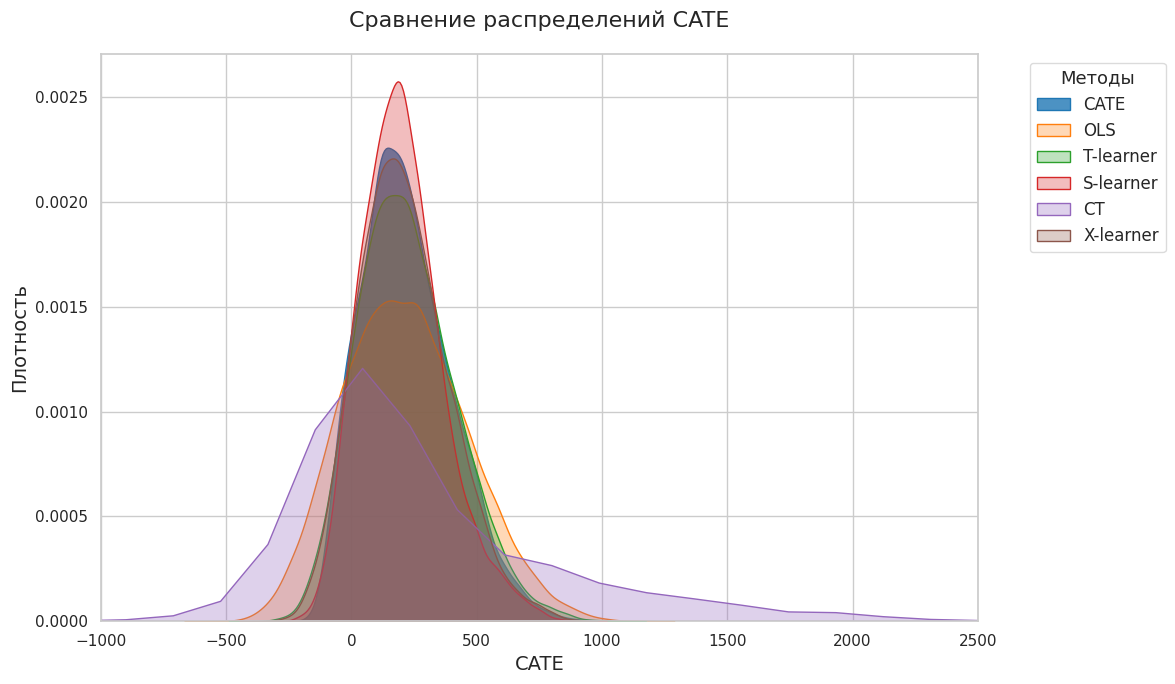

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 7))

colors = [
    '#1f77b4',
    '#ff7f0e',
    '#2ca02c',
    '#d62728',
    '#9467bd',
    '#8c564b',
    '#e377c2'
]

sns.kdeplot(CATE, fill=True, color=colors[0], label='CATE', alpha=0.8)
sns.kdeplot(CATE_ls, fill=True, color=colors[1], label='OLS', alpha=0.3)
sns.kdeplot(CATE_T, fill=True, color=colors[2], label='T-learner', alpha=0.3)
sns.kdeplot(CATE_S, fill=True, color=colors[3], label='S-learner', alpha=0.3)
sns.kdeplot(CATE_CT, fill=True, color=colors[4], label='CT', alpha=0.3)
sns.kdeplot(CATE_X, fill=True, color=colors[5], label='X-learner', alpha=0.3)


plt.xlim(left=-1000, right=2500)

plt.title('Сравнение распределений CATE', fontsize=16, pad=20)
plt.xlabel('CATE', fontsize=14)
plt.ylabel('Плотность', fontsize=14)
legend = plt.legend(title='Методы', title_fontsize=13, fontsize=12,
                   bbox_to_anchor=(1.05, 1), loc='upper left')

legend.get_frame().set_alpha(0.7)

plt.tight_layout()
plt.show()

Видно, что методы S-learner, T-learner, X-learner визуально дают результаты, похожие на истинное CATE. Методы МНК и трансформации классов обладают большой дисперсией прогноза. Также метод трансформации классов визуально наиболее далек от истинного CATE, возможно, потому что метод обучается на псевдоисходах, а не реальных значениях alcohol.

In [ ]:
#R-learner
np.random.seed(141)
y = df ['alcohol'].values
t = df['stress'].values
X = df.drop(columns=['alcohol', 'stress', 'boss'])
X = X.select_dtypes(include=  [np.number])

model_e = LogisticRegression(max_iter=1000)
model_e.fit (X, t)
e_hat = model_e. predict_proba (X)[:, 1]

model_mu = GradientBoostingRegressor(**{'learning_rate': 0.2, 'n_estimators': 150})
model_mu.fit (X, y)

mu_hat = model_mu.predict (X)
res_y = y - mu_hat
res_t = t - e_hat

model_tau = GradientBoostingRegressor (**{'learning_rate':0.2, 'n_estimators': 150})
model_tau. fit(X, res_y * res_t)
CATE_R = model_tau.predict (X)
CATE_R

array([  8.17626545, -22.40524249,   4.83444616, ...,  12.42007213,
        12.1920931 , -24.34806158])

 R-learner учитывает остатки, поэтому получается двухступенчатых подход. Сначала получаем базовый результат E(Stress) - вероятность получить стресс в зависимости от контрольных переменных, затем E(Alcohol), без влияния stress. Получаем остатки на эти модели, используем регрессию на их произведение. Математическое ожидание их произведения - CATE.

 Эта модель позволяет находить более сложные взаимосвязи, так как использует два этапа и работает с остатками. Однако, она очень сильно зависит от качества изначальных двух моделей и нуждается в большом объеме данных для точных оценок.

In [ ]:
CATE_mat = pd.DataFrame({'True': CATE, 'LS': CATE_ls, 'T-learner': CATE_T,
                         'S-learner': CATE_S, 'IPW': CATE_CT, 'X-learner': CATE_X , 'R-learner': CATE_R})
CATE_mat

,True,LS,T-learner,S-learner,IPW,X-learner,R-learner
0,69,102,42,93,244,79,31
1,59,37,1,12,137,7,-99
2,85,18,74,117,-11,97,22
3,281,279,304,253,565,293,80
4,7,-78,72,58,-85,70,45
...,...,...,...,...,...,...,...
14995,46,132,54,124,209,89,41
14996,343,407,308,146,919,143,-41
14997,72,52,56,66,301,61,33
14998,135,58,167,128,-25,159,71


### №5.7

In [ ]:
CATE_MSE_real = pd.DataFrame(data    = [np.mean((CATE_ls  - CATE) ** 2),
                                    np.mean((CATE_T   - CATE) ** 2),
                                    np.mean((CATE_S   - CATE) ** 2),
                                    np.mean((CATE_CT  - CATE) ** 2),
                                    np.mean((CATE_X  - CATE) ** 2),
                                    np.mean((CATE_R  - CATE) ** 2)],
                         index   = ['LS', 'T-learner', 'S-learner', 'CT', 'X-learner', 'R-learner'],
                         columns = ['MSE'])
print(CATE_MSE_real)

              MSE
LS         11,736
T-learner   5,492
S-learner   5,045
CT        258,693
X-learner   6,031
R-learner  66,408


Лучшая модель: S-learner

Она обучает одну общую модель, в которую входит признак воздействия и его взаимодействие с признаками. Возможно, T- и X-learner, которые разделяют выборку, могут переобучаться на отдельных подвыборках.

На методе трансформации классов (CT) при оценке вероятности могли быть экстремальные значения, близкие 0 или 1, что давало неадекватные значения alcohol.

In [ ]:
CATE_MSE_pseudo = pd.DataFrame(data    = [np.mean((alcohol_pseudo  - CATE_ls) ** 2),
                                    np.mean((alcohol_pseudo   - CATE_T) ** 2),
                                    np.mean((alcohol_pseudo   - CATE_S) ** 2),
                                    np.mean((alcohol_pseudo  - CATE_CT) ** 2),
                                    np.mean((alcohol_pseudo  - CATE_X) ** 2),
                                    np.mean((alcohol_pseudo  - CATE_R) ** 2)],
                         index   = ['LS', 'T-learner', 'S-learner', 'CT', 'X-learner','R-learner'],
                         columns = ['MSE'])
pd.set_option('display.float_format', '{:,.0f}'.format)
print(CATE_MSE_pseudo)

                 MSE
LS        21,409,195
T-learner 21,371,101
S-learner 21,387,481
CT        20,659,213
X-learner 21,396,197
R-learner 21,267,458


Метод трансформации классов показывает самую низкую ошибку, потому что этот метод и обучался напрямую на alcohol_pseudo, которое и есть псевдо-таргет. Остальные методы в целом близки по значениям MSE.

Результаты могут помочь при разработке государственных анти-алкогольных программ. Оценка условного эффекта позволяет предсказать, как уменьшение стрессовых факторов (например, через улучшение условий труда или социальную поддержку) может снизить потребление алкоголя.

Это важно для моделирования экономического эффекта — меньше расходов на лечение, меньше потерь от алкоголизма.

### №5.8

Здесь используются те же методы прогнозирования ATE. Однако для оценки вероятности переменной stress или для мат.ожидания alcohol будут использованы наименее точные методы машинного обучение (которые мы смогли наблюдать на подборе гиперпараметров в частях 3-4)

In [ ]:
#В целом, регуляризация не помогла.
#МНК, Лассо и Ридж одинаковы, но чуть худше оказалась Ридж.

import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
import statsmodels.api as sm

np.random.seed(141)

y0 = df.loc[stress == 0, 'alcohol'].values
x0 = df.loc[stress == 0, df.columns.drop(['alcohol', 'boss', 'stress'])]
x0 = sm.add_constant(x0).values

y1 = df.loc[stress == 1, 'alcohol'].values
x1 = df.loc[stress == 1, df.columns.drop(['alcohol', 'boss', 'stress'])]
x1 = sm.add_constant(x1).values

ridge0 = Ridge(alpha=0.0001)
ridge1 = Ridge(alpha=0.0001)

ridge0.fit(x0, y0)
ridge1.fit(x1, y1)

x = df.loc[:, df.columns.drop(['alcohol', 'boss', 'stress'])]
x = sm.add_constant(x).values

alcohol0_ridge = ridge0.predict(x)
alcohol1_ridge = ridge1.predict(x)

CATE_ridge_bad = alcohol1_ridge - alcohol0_ridge
ATE_ridge_bad = np.mean(CATE_ls)

print(ATE_ridge_bad)

215.80723486555615


In [ ]:
#с помощью условных мат ожиданий
np.random.seed(141)
y0 = df.loc[stress == 0, ['alcohol']]
x0 = df.loc[stress == 0, df.columns.drop(['alcohol', 'boss', 'stress'])]
x0 = sm.add_constant(x0)

y1 = df.loc[stress == 1, ['alcohol']]
x1 = df.loc[stress == 1, df.columns.drop(['alcohol', 'boss', 'stress'])]
x1 = sm.add_constant(x1)

x = df.loc[:, df.columns.drop(['alcohol', 'boss', 'stress'])]
x = sm.add_constant(x)

#тут худшая модель на прогноз алкоголя
reg3 = KNeighborsRegressor(n_neighbors=5)
reg3.fit(x0, y0)

alcohol0_reg3 = reg3.predict(x)

reg3.fit(x1, y1)

alcohol1_reg3 = reg3.predict(x)

CATE_T_bad = alcohol1_reg3 - alcohol0_reg3

ATE_CM_bad = np.mean(CATE_T)
print(ATE_CM_bad)

221.4920886912826


In [ ]:
#обратные условные вероятности
#тут пришлось брать не самый плохой метод (иначе получились нулевые вероятности), а второй самый худший

np.random.seed(141)
target = df.loc[:, ['stress']]
features = df.loc[:, df.columns.drop(['alcohol', 'boss', 'stress'])]

##тут худшая модель на прогноз стресса
clf = GaussianNB()
clf.fit(features, target)

prob_clf  = clf.predict_proba(features)[:, 1]

alcohol_pseudo = (alcohol * stress) / prob_clf  - (alcohol * (1 - stress)) / (1 - prob_clf)

ATE_IPW_bad = np.mean(alcohol_pseudo)
print(ATE_IPW_bad)

-37.60249563284586


In [ ]:
#двойная устойчивость
np.random.seed(141)

##тут худшая модель на прогноз алкоголя
reg = KNeighborsRegressor(n_neighbors=5)

y = df.loc[:, ['alcohol']]
x = df.loc[:, df.columns.drop(['alcohol', 'boss'])]
x0 = deepcopy(x)
x0['stress'] = 0
x1 = deepcopy(x)
x1['stress'] = 1

reg.fit(x, y)

alcohol1_clf = reg.predict(x1)
alcohol0_clf = reg.predict(x0)

ATE_DR_bad = np.mean((alcohol1_clf - alcohol0_clf) + \
                 stress * (alcohol - alcohol1_clf) / prob_clf - \
                 (1 - stress) * (alcohol - alcohol0_clf) / (1 - prob_clf))
print(ATE_DR_bad)

149.6485858485268


In [ ]:
# ДМО
np.random.seed(141)
dml_standard_data = dml.DoubleMLData(
                            data   = df,
                            y_col  = 'alcohol',
                            d_cols = 'stress',
                            x_cols = ['gender', 'age', 'income', 'city', 'depressive', 'discounts'])

# худший прогноз для алкоголя
g_Y = KNeighborsRegressor(n_neighbors=5)

# худшая модель на классификацию
g_T = KNeighborsClassifier(n_neighbors=7)

dml_standard = dml.DoubleMLIRM(obj_dml_data = dml_standard_data,
                               ml_g         = g_Y,
                               ml_m         = g_T,
                               n_rep        = 1,
                               n_folds      = 5)

dml_standard.fit()

ATE_dml_standard_bad = dml_standard.coef[0]
print(ATE_dml_standard_bad)

397.4782901422069


In [ ]:
ate_data = {
    'model': ['ATE_ls', 'ATE_CM', 'ATE_IPW', 'ATE_DR', 'ATE_dml'],
    'best_score': [ATE_ls, ATE_CM, ATE_IPW, ATE_DR, ATE_dml_standard],
    'worst_score': [ATE_ridge_bad, ATE_CM_bad, ATE_IPW_bad, ATE_DR_bad, ATE_dml_standard_bad]
}

df_scores = pd.DataFrame(ate_data)
df_scores

,model,best_score,worst_score
0,ATE_ls,216,216
1,ATE_CM,221,221
2,ATE_IPW,267,-38
3,ATE_DR,203,150
4,ATE_dml,221,397


Мы видим, что результаты неустойчивосты к качеству используемых методов машинного обучения. Особенно это заметно, где многое зависит от задачи классификации, так как худшая модель KNN достаточно плохо с ней справлялась.


Прогнозирование LATE, но с плохими моделями

In [ ]:
# БЕЗ DEPRESSIVE, не учитываем эндогенность
#Данные в формате, необходимом для применения DML,
np.random.seed(141)
dml_standard2_data = dml.DoubleMLData(
                             data   = df,
                             y_col  = 'alcohol',
                             d_cols = 'stress',
                             x_cols = ['gender', 'age', 'income', 'city', 'discounts'])

dml_standard2_bad = dml.DoubleMLIRM(obj_dml_data = dml_standard2_data,
                                ml_g         = g_Y,
                                ml_m         = g_T,
                                n_rep        = 1,
                                n_folds      = 5)

dml_standard2_bad.fit()

print(dml_standard2_bad)

LATE_dml_standard2_bad = dml_standard2_bad.coef[0]
LATE_dml_standard2_bad

================== DoubleMLIRM Object ==================

------------------ Data summary      ------------------
Outcome variable: alcohol
Treatment variable(s): ['stress']
Covariates: ['gender', 'age', 'income', 'city', 'discounts']
Instrument variable(s): None
No. Observations: 15000

------------------ Score & algorithm ------------------
Score function: ATE

------------------ Machine learner   ------------------
Learner ml_g: KNeighborsRegressor()
Learner ml_m: KNeighborsClassifier(n_neighbors=7)
Out-of-sample Performance:
Regression:
Learner ml_g0 RMSE: [[161.5028091]]
Learner ml_g1 RMSE: [[429.84233613]]
Classification:
Learner ml_m Log Loss: [[0.77590827]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1

------------------ Fit summary       ------------------
        coef  std err  t  P>|t|  2.5 %  97.5 %
stress   407       33 12      0    342     472


406.9422031790969

In [ ]:
# С инструментом
#ДМО
np.random.seed(141)
dml_iv_data = dml.DoubleMLData(data   = df,
                               y_col  = 'alcohol',
                               d_cols = 'stress',
                               z_cols = 'boss',
                               x_cols = ['gender', 'age', 'income', 'city', 'discounts'])

# для инструмента
g_Z = KNeighborsClassifier(n_neighbors=7)

dml_iv_bad = dml.DoubleMLIIVM(obj_dml_data = dml_iv_data,
                          ml_g         = g_Y,
                          ml_m         = g_Z,
                          ml_r         = g_T,
                          n_rep        = 1,
                          n_folds      = 5)

dml_iv_bad.fit()

print(dml_iv_bad)

LATE_dml_iv_bad = dml_iv_bad.coef[0]
print(LATE_dml_iv_bad)

================== DoubleMLIIVM Object ==================

------------------ Data summary      ------------------
Outcome variable: alcohol
Treatment variable(s): ['stress']
Covariates: ['gender', 'age', 'income', 'city', 'discounts']
Instrument variable(s): ['boss']
No. Observations: 15000

------------------ Score & algorithm ------------------
Score function: LATE

------------------ Machine learner   ------------------
Learner ml_g: KNeighborsRegressor()
Learner ml_m: KNeighborsClassifier(n_neighbors=7)
Learner ml_r: KNeighborsClassifier(n_neighbors=7)
Out-of-sample Performance:
Regression:
Learner ml_g0 RMSE: [[395.48712728]]
Learner ml_g1 RMSE: [[369.71952903]]
Classification:
Learner ml_m Log Loss: [[0.73797635]]
Learner ml_r0 Log Loss: [[1.69354471]]
Learner ml_r1 Log Loss: [[1.36948035]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1

------------------ Fit summary       ------------------
        coef  std err  t  P>|t|  2

In [ ]:
late_data = {
    'model': ['Без инструмента', 'С инструментом'],
    'best_score': [LATE_dml_standard2, LATE_dml_iv],
    'worst_score': [LATE_dml_standard2_bad, LATE_dml_iv_bad]
}

df_scores = pd.DataFrame(late_data)
df_scores

,model,best_score,worst_score
0,Без инструмента,495,407
1,С инструментом,184,-85


Наблюдаем очень сильную чувствительность к используемым методам. В модели с инструментом нам пришлось использовать плохой метод KNN 2 раза (при прогнозировании переменной воздействия, и инструмента), поэтому результат сильно хуже.

### №5.9

В данном разделе мы оценили
- эффекты воздействия (TE)
- средние эффекты воздействия (ATE)
- локальные средние эффекты воздействия (LATE)
- условные средние эффектов воздействия (CATE).
Использовали для этого МНК, взвешивания на обратные вероятности (IPW), метод с двойной устойчивостью (DR), двойного машинного обучения (DML).

1. Оценка среднего эффекта воздействия (ATE)

Что касается ATE, наиболее точную оценку (к истиной 220.8) давал метод двойного машинного обучения (220.7).

2. Оценка локального среднего эффекта воздействия (LATE)

Мы продемонстрировали, насколько важен подбор и учет инструментальной переменной при возможной эндогенности. Иначе возможны пере- или недооценки воздействия переменной.

3. Оценка условных средних эффектов воздействия (CATE).

В данном случае использовали различные подходы, такие как МНК, S-learner, T-learner, метод трансформации классов, X-learner. Лучше всего себя показал S-learner, который оценивал CATE не разделяя выборку.

4. Устойчивость результатов.

К сожалению, использование машинного обучения очень чувствительно к используемым методом. Поэтому, важно изначально подбирать наиболее качественные методы для оценок вероятностей или мат. ожиданий.

